In [1]:
import sys 
sys.path.append("/mnt/shared/users/wessim.omezzine/hip-analysis")
from hip.analysis.aoi import AnalysisArea
from hip.analysis.data._datasources import DATASOURCE_CONFIGS
import os
import dask
from dask.distributed import Client, progress
import rioxarray as rxr
import glob
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import rasterio

import warnings
warnings.filterwarnings("ignore")

import s3fs
import xarray as xr
import dask
# Create a dask client to distribute (speed up) the coputation

# if dashboard.link set to default value and running behind hub, make dashboard link go via proxy
if dask.config.get("distributed.dashboard.link") == '{scheme}://{host}:{port}/status':
    jup_prefix = os.environ.get('JUPYTERHUB_SERVICE_PREFIX')
    if jup_prefix is not None:
        jup_prefix = jup_prefix.rstrip('/')
        dask.config.set({"distributed.dashboard.link": f"{jup_prefix}/proxy/{{port}}/status"})

client = Client()
client

GDAL_DATA                    = /envs/user/fix_hdc/share/gdal
GDAL_DISABLE_READDIR_ON_OPEN = EMPTY_DIR
GDAL_HTTP_MAX_RETRY          = 10
GDAL_HTTP_RETRY_DELAY        = 0.5
AWS_ACCESS_KEY_ID            = xx..xx
AWS_SECRET_ACCESS_KEY        = xx..xx
AWS_SESSION_TOKEN            = xx..xx


INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:35523
INFO:distributed.scheduler:  dashboard at:  /user/wessim.omezzine/proxy/8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40157'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33059'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43941'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:42559'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:40989', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:40989
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:55486
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:45655', na

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/wessim.omezzine/proxy/8787/status,
Dashboard: /user/wessim.omezzine/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35523,Workers: 4
Dashboard: /user/wessim.omezzine/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.20 GiB
Comm: tcp://127.0.0.1:35147,Total threads: 1
Dashboard: /user/wessim.omezzine/proxy/33287/status,Memory: 3.80 GiB
Nanny: tcp://127.0.0.1:40157,


In [3]:
def seasonality(bbox,start=True):
    
    longitude_1, longitude_2  = bbox[0], bbox[2] 
    lattitude_1, lattitude_2  = bbox[1], bbox[3]
    ## Read a particular index for each year 
    
    if start:
        file_list = [f"/s3/scratch/public-share/seasonality/1_soc_eoc/soc_1_idx_from_r1h_lta.tif" ]
    else:
        file_list = [f"/s3/scratch/public-share/seasonality/1_soc_eoc/eoc_1_idx_from_r1h_lta.tif" ]

    
    print(longitude_1, longitude_2)
    test = xr.open_mfdataset(file_list, 
                             engine='rasterio', 
                             combine='nested',
                             parallel=True)
    
    print(test)
    data = test.band_data.isel(band=0)
    # data = data.sel(x=slice(lattitude_1, lattitude_2), y =slice(longitude_1, longitude_2))
    data = data.sel(y=slice(lattitude_2, lattitude_1))
    data = data.sel(x=slice(longitude_1, longitude_2))
    
    
    # data.sel(latitude=slice(lattitude_1, lattitude_2), longitude=slice(longitude_1, longitude_2), method='nearest')
    return data
    




# Jordan

In [4]:
region="Jordan_more"

## Import RFH CHIRPS

In [5]:
bbox = (35.595703,29.983487,41.693115,33.916013) #Sudan
area = AnalysisArea(
    bbox=bbox,
    datetime_range="1983-01-01/2023-06-30"  # change the starting date 1983  
)
rfh = area.get_dataset(["CHIRPS","rfh_dekad"])
r1h = area.get_dataset(["CHIRPS","r1h_dekad"])


In [6]:
rfh = rfh.load()
r1h = r1h.load()


### Extract Seasonality

In [7]:
start_season =2
end_season =5

### Agregation over every month

In [8]:
rfh_resample = rfh.resample(time='M').sum()
r1h_resample = r1h.resample(time='M').sum()


## Import ECMWF Prediction

In [9]:
path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/0{start_season}/01'

with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":70, "ensemble":-1}, engine='zarr')
ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 

In [10]:
da_issue = ds_issue.tp.load()

In [11]:
da_issue = da_issue.mean("ensemble") #Output 1 ensemble
da_issue = da_issue.groupby("time.year").apply(lambda da :  da.diff(dim='time', n=1))
#da_issue = da_issue.diff(dim='time', n=1).fillna(0)  # Non cumulative

In [12]:
da_issue.longitude

<xarray.DataArray 'longitude' (longitude: 6)>
array([36.5, 37.5, 38.5, 39.5, 40.5, 41.5])
Coordinates:
  * longitude    (longitude) float64 36.5 37.5 38.5 39.5 40.5 41.5
    spatial_ref  int32 4326

In [13]:
# path_issue = f's3://wfp-seasmon/zarr/seasonal-forecasts/{mm}/01'

# with dask.config.set(**{'array.slicing.split_large_chunks': False}):
#     ds_issue = xr.open_mfdataset(f'{path_issue}/*.zarr', chunks={"latitude":36, "longitude":36, "ensemble":-1}, engine='zarr')
    
# ds_issue = ds_issue.sel(latitude = slice(bbox[3], bbox[1]),longitude = slice(bbox[0], bbox[2])) 
# da_issue = ds_issue.tp.load()
# da_issue = da_issue.mean("ensemble")


da_monthly_sum = da_issue.resample(time='M').sum()
da_monthly_sum_season  = da_monthly_sum.sel(time=(da_monthly_sum['time.month'] >= start_season) & (da_monthly_sum['time.month'] <= end_season), drop=True) 
da_monthly_sum_season_near = da_monthly_sum_season.rio.reproject(rfh_resample.rio.crs, 
                                                             resolution=(-0.05,0.05), 
                                                             resampling=rasterio.enums.Resampling.nearest)

da_monthly_sum_season_near = da_monthly_sum_season_near.rename({'y': 'latitude', 'x': 'longitude'})
da_monthly_sum_season_near = da_monthly_sum_season_near 

rfh_resample = rfh_resample.sel(latitude = slice(32.5, 30.5), longitude = slice(36.5, 41.5))
r1h_resample = r1h_resample.sel(latitude = slice(32.5, 30.5), longitude = slice(36.5, 41.5))
da_monthly_sum_season_near_resample =da_monthly_sum_season_near.sel(latitude = rfh_resample.latitude.values, longitude= rfh_resample.longitude.values, method = "nearest")


latitude_size, longitude_size = 32,32

rfh = rfh_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
r1h = r1h_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
da_monthly_sum_season_near  = da_monthly_sum_season_near_resample.isel(latitude=slice(0,latitude_size), longitude=slice(0,longitude_size))
# da_monthly_sum_season_near.to_netcdf(f'Data/Downscaling/Rainfall/Jordan/data/da_monthly_sum_season_near_01.nc')

In [14]:
s = rfh.max() / da_monthly_sum_season_near.values.max()
s

<xarray.DataArray 'band' ()>
array(2564.71927622)
Coordinates:
    spatial_ref  int32 4326

In [15]:
scale_rate = 10

rfh = rfh.sel(time=(rfh['time.month'] >= start_season) & (rfh['time.month'] <= end_season), drop=True) 
r1h = r1h.sel(time=(r1h['time.month'] >= start_season) & (r1h['time.month'] <= end_season), drop=True) 
scaling_factors = rfh.max() / da_monthly_sum_season_near.values.max()



scaling_factors = 4000


forecast = da_monthly_sum_season_near*scaling_factors
forecast

<xarray.DataArray 'tp' (time: 172, latitude: 32, longitude: 32)>
array([[[ 96.80298  ,  96.80298  ,  96.80298  , ...,  28.779297 ,
          26.554565 ,  26.554565 ],
        [ 96.80298  ,  96.80298  ,  96.80298  , ...,  28.779297 ,
          26.554565 ,  26.554565 ],
        [ 96.80298  ,  96.80298  ,  96.80298  , ...,  28.779297 ,
          26.554565 ,  26.554565 ],
        ...,
        [ 36.321106 ,  36.321106 ,  36.321106 , ...,  19.050903 ,
          19.320679 ,  19.320679 ],
        [ 17.474365 ,  17.474365 ,  17.474365 , ...,  11.470032 ,
          12.027892 ,  12.027892 ],
        [ 17.474365 ,  17.474365 ,  17.474365 , ...,  11.470032 ,
          12.027892 ,  12.027892 ]],

       [[127.33641  , 127.33641  , 127.33641  , ...,  64.69238  ,
          59.606934 ,  59.606934 ],
        [127.33641  , 127.33641  , 127.33641  , ...,  64.69238  ,
          59.606934 ,  59.606934 ],
        [127.33641  , 127.33641  , 127.33641  , ...,  64.69238  ,
          59.606934 ,  59.606934 ],
...
        [ 28.054632 ,  28.054632 ,  28.054632 , ...,  23.200535 ,
          28.822958 ,  28.822958 ],
        [ 22.2168   ,  22.2168   ,  22.2168   , ...,  19.559973 ,
          17.661896 ,  17.661896 ],
        [ 22.2168   ,  22.2168   ,  22.2168   , ...,  19.559973 ,
          17.661896 ,  17.661896 ]],

       [[ 20.441114 ,  20.441114 ,  20.441114 , ...,  14.591321 ,
          12.95653  ,  12.95653  ],
        [ 20.441114 ,  20.441114 ,  20.441114 , ...,  14.591321 ,
          12.95653  ,  12.95653  ],
        [ 20.441114 ,  20.441114 ,  20.441114 , ...,  14.591321 ,
          12.95653  ,  12.95653  ],
        ...,
        [  9.550527 ,   9.550527 ,   9.550527 , ...,   8.432746 ,
          13.267681 ,  13.267681 ],
        [ 10.065131 ,  10.065131 ,  10.065131 , ...,   9.861678 ,
          10.0435915,  10.0435915],
        [ 10.065131 ,  10.065131 ,  10.065131 , ...,   9.861678 ,
          10.0435915,  10.0435915]]], dtype=float32)
Coordinates:
  * longitude    (longitude) float64 36.52 36.57 36.62 ... 37.98 38.02 38.07
  * latitude     (latitude) float64 32.48 32.43 32.38 ... 31.03 30.98 30.93
  * time         (time) datetime64[ns] 1981-02-28 1981-03-31 ... 2023-05-31
    spatial_ref  int64 0

In [16]:
forecast.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
rfh.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')
r1h.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/r1h_monthly.nc')


# LTA

In [17]:
forecast_near = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')
# forecast_near = forecast_near.update(forecast_near*1e4) ## CHANGE!!!
rfh = xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/rfh_monthly.nc')

In [18]:
rfh_lta = rfh.sel(time=slice("1983-02-28","2018-05-31"))
rfh_lta  = rfh_lta .groupby(rfh_lta.time.dt.strftime("%m-%d")).mean()
rfh_lta = rfh_lta.sel(strftime=rfh.time.dt.strftime("%m-%d"))

In [19]:
rfh_lta.to_netcdf(f'Data/Downscaling/Rainfall/{region}/data/rfh_lta.nc')

In [20]:
xr.open_dataset(f'Data/Downscaling/Rainfall/{region}/data/forecast.nc')

<xarray.Dataset>
Dimensions:      (longitude: 32, latitude: 32, time: 172)
Coordinates:
  * longitude    (longitude) float64 36.52 36.57 36.62 ... 37.98 38.02 38.07
  * latitude     (latitude) float64 32.48 32.43 32.38 ... 31.03 30.98 30.93
  * time         (time) datetime64[ns] 1981-02-28 1981-03-31 ... 2023-05-31
    spatial_ref  int64 ...
Data variables:
    tp           (time, latitude, longitude) float32 ...

In [21]:
forecast_near

<xarray.Dataset>
Dimensions:      (longitude: 32, latitude: 32, time: 172)
Coordinates:
  * longitude    (longitude) float64 36.52 36.57 36.62 ... 37.98 38.02 38.07
  * latitude     (latitude) float64 32.48 32.43 32.38 ... 31.03 30.98 30.93
  * time         (time) datetime64[ns] 1981-02-28 1981-03-31 ... 2023-05-31
    spatial_ref  int64 ...
Data variables:
    tp           (time, latitude, longitude) float32 ...

NameError: name 'scaled_forecast_near' is not defined

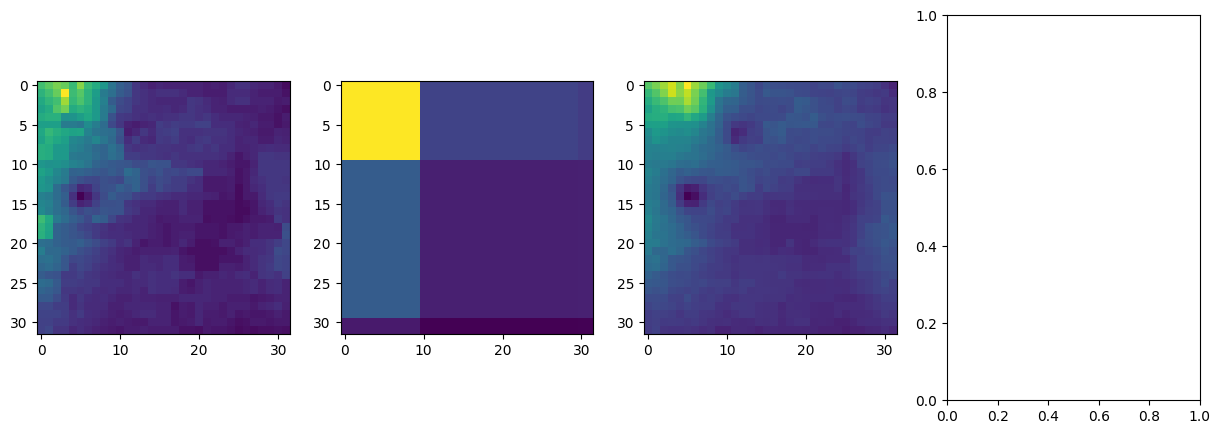

In [22]:
for index in range(4):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    im1 = axes[0].imshow(rfh['band'][index])

    im2 = axes[1].imshow(forecast_near['tp'][index])

    im3 = axes[2].imshow(rfh_lta['band'][index])
    
    im4 = axes[3].imshow(scaled_forecast_near['tp'][index])

    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)
    fig.colorbar(im4)

    plt.show()


# Bilinear interpolation 

In [36]:
def bilinear_interpolate (forecast,verbose=False):
    new_height = forecast.shape[1]
    new_width = forecast.shape[2]
    forecast_resample=forecast[0]
    image_tensor  = forecast_resample[:30:5,:30:5]
    
    rescaled_image = F.interpolate(image_tensor.unsqueeze(0).unsqueeze(0), size=(new_height, new_width), mode='bilinear', align_corners=False)[0]
    
    if verbose:
        
        plt.imshow(rescaled_image)
        plt.show()
        
    
    
    return rescaled_image

# Weighted Mask

In [37]:
import numpy as np
# Define a custom weighting function (e.g., higher weights in center)
def custom_weight_function_mean(square):
    normalized_weights = square/np.mean(square)
    return normalized_weights

def custom_weight_function(square):
    local_std = np.std(square)
    normalized_weights = local_std / np.mean(square)
    
    
    return normalized_weights

def Downscale_Weight(rfh_lta,forecast, verbose=False):

    # Initialize an empty weight mask
    weight_mask = np.zeros_like(forecast)

    # Compute weights and apply them
    
    step = 10
    for row in range(0,30,step):
        for col in range(0,60,10):
            rfh_lta_square = rfh_lta[row:row + step, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, col:col + step] = weights
            
    
    for row in range(0,32,step):
            rfh_lta_square = rfh_lta[row:row + step, 60:]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, 60:] = weights
        
        
    for col in range(0,64,step):
            rfh_lta_square = rfh_lta[30:, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[30:, col:col + step] = weights



    # Apply the weight mask to forecast
    weighted_forecast = forecast * weight_mask


    if verbose:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(forecast)
        axes[1].imshow(rfh_lta)
        axes[2].imshow(weighted_forecast)
        axes[3].imshow(weighted_forecast-rfh_lta)

        axes[0].set_title(f"forecastKm", fontsize='xx-large')
        axes[1].set_title(f"rfh_lta", fontsize='xx-large')
        axes[2].set_title(f"NDVI_Downscaled_det", fontsize='xx-large')
        axes[3].set_title(f"Bias", fontsize='xx-large')
        plt.show()

    return weighted_forecast

In [77]:
path_ecmwf = f"/mnt/shared/users/wessim.omezzine/ClimaX/Data/Downscaling/Rainfall/{region}/data/"
path_chirps = f"/mnt/shared/users/wessim.omezzine/ClimaX/Data/Downscaling/Rainfall/{region}/data/"
save_dir = f"/mnt/shared/users/wessim.omezzine/ClimaX/Data/Downscaling/Rainfall/{region}/data_npz/" 

In [81]:
rfh = xr.open_dataset(path_chirps+"rfh_monthly.nc").fillna(0)    
rfh_lta = xr.open_dataset(path_chirps+"rfh_lta.nc").fillna(0)
forecast = xr.open_dataset(path_ecmwf+"forecast.nc").fillna(0)


##### TO CHANGE!!!!
dimensions_lat = 32
dimensions_lon = 64
# ndvi_1 = select_shape(ndvi_1, dimensions, dimensions, True )
# ndvi_1_lta = select_shape(ndvi_1_lta, dimensions, dimensions, True )
# ndvi_5 = select_shape(ndvi_5, ndvi_5.dims["latitude"], ndvi_5.dims["longitude"], True)



variables = {
"rfh": rfh,
"rfh_lta": rfh_lta,
"forecast": forecast,

}
   
variables['rfh'].sel(time=variables['rfh'].time.dt.year == 1983)


<xarray.Dataset>
Dimensions:      (time: 4, latitude: 32, longitude: 64)
Coordinates:
  * latitude     (latitude) float64 32.48 32.43 32.38 ... 31.03 30.98 30.93
  * longitude    (longitude) float64 36.53 36.58 36.62 ... 39.58 39.62 39.68
    spatial_ref  int32 ...
  * time         (time) datetime64[ns] 1983-02-28 1983-03-31 ... 1983-05-31
Data variables:
    band         (time, latitude, longitude) float64 85.0 90.0 95.0 ... 5.0 5.0

# ClimaX

In [ ]:
! python src/data_preprocessing/nc2np_equally_ecmwf_downscaling.py

In [ ]:
ClimaX/Data/Downscaling/Rainfall/data/rfh_monthly.nc

In [29]:
vars(np.load('Data/Downscaling/Rainfall/Jordan_more/data_npz/normalize_std_input.npz'))

{'_files': ['rfh_lta.npy', 'forecast.npy'],
 'files': ['rfh_lta', 'forecast'],
 'allow_pickle': False,
 'max_header_size': 10000,
 'pickle_kwargs': {'encoding': 'ASCII', 'fix_imports': True},
 'zip': None,
 'f': None,
 'fid': None}

# Results

In [38]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F
from prettytable import PrettyTable

from skimage.metrics import structural_similarity as ssim


from climax.climate_downscaling.module import ClimateDownscalingModule
from climax.climate_downscaling.datamodule import ClimateDownscalingDataModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX


TASK_TO_RANGE = {
    '0 days' : 0,
    '10 days' : 1,
    '40 days': 4,
    '50 days': 5,
    '60 days': 6,
    '20 days': 2,
    '30 days': 3,
}

In [39]:
def plot_pred(tensors, var_name, pred_task, time):
    
    index = 0
    fig, axes = plt.subplots(1, 4, figsize=(28, 3), squeeze = False)
    
    
    
    image1_np = tensors[0][time].detach().squeeze().cpu().numpy()
    image2_np = tensors[1][time].detach().squeeze().cpu().numpy()
    image3_np = tensors[2][time].detach().squeeze().cpu().numpy()
    vmin = min(np.min(image2_np), np.min(image3_np))
    vmax = max(np.max(image2_np), np.max(image3_np))
    
    
    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        if i==1 or i==2 : 
            im = ax.imshow(tensor[time].detach().squeeze().cpu().numpy(),vmin=vmin, vmax=vmax)

        else : 
            im = ax.imshow(tensor[time].detach().squeeze().cpu().numpy())
            
            
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off



        axes[index][0].text(-10, 64, var_name, fontsize=28, rotation=90, va='center', ha='center')
        axes[index][0].set_title(f"Initial condition", fontsize='xx-large')
        axes[index][1].set_title(f"Ground truth", fontsize='xx-large')
        axes[index][2].set_title(f"Downscaled", fontsize='xx-large')
        axes[index][3].set_title(f"Bias", fontsize='xx-large')

    plt.show()


def plot_inputs(tensors, var_name, pred_task,time):
    index = 0
    fig, axes = plt.subplots(1, 3, figsize=(28, 2), squeeze = False)
    
    timesteps = tensors[0].shape[0]
    
    
    for i, tensor in enumerate(tensors):
        ax = axes[index][i]
        im = ax.imshow(tensor[time].detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        ) # labels along the bottom edge are off
        ax.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,        # ticks along the top edge are off
            labelleft=False
        ) # labels along the bottom edge are off



    axes[index][0].text(-10, 64, "Inputs", fontsize=28, rotation=90, va='center', ha='center')
    axes[index][0].set_title(f"Forecast", fontsize='xx-large')
    axes[index][1].set_title(f"RFH_LTA", fontsize='xx-large')
    axes[index][2].set_title(f"R1H", fontsize='xx-large')



    plt.show()
    
    

    


In [40]:
def visualize_downscale(model_module, data_module,mean_norm, std_norm, pred_task, var_name, var_id,data_path=None, save_path = None, desired_batch_index = 25):
    
    model_module.eval()
    
    if torch.cuda.is_available():
         model_module.cuda()
    else:
         model_module.cpu()
    

    dataloader = data_module.test_dataloader()
    
   

    for batch_idx, batch_data in enumerate(dataloader, 1):        
        if batch_idx == desired_batch_index:
            # Process the nth batch (e.g., 10th batch)
            x, y, lead_times, in_vars, out_vars = batch_data
            
    
#     print("x.shape", x.shape)
#     print("y.shape", y.shape)
    
    
    if torch.cuda.is_available():
        lead_times = lead_times.cuda()
    else:
        lead_times = lead_times.cpu()

            
    if data_path!=None:
        x_input, y_input, norm_x, norm_y = preprocess(pred_task,model_module, data_module,mean_norm, std_norm,var_id,data_path, verbose=False)
        x = norm_x
        y = norm_y
    
    if torch.cuda.is_available():
        x = x.cuda()
        y = y.cuda()
    else:
        x = x.cpu()
        y = y.cpu()
    
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, None, model_module.lat)
    
    inv_normalize = model_module.denormalization
    
    
    if data_path!=None:
        tensors = [x_input[:,0],x_input[:,1], x_input[:,3]]

    else:
        print(x.shape)
        tensors = [inv_normalize(x[:,0]), inv_normalize(x[:,1]),inv_normalize(x[:,2])]
        init_condition = inv_normalize(x[:,0])
    
    
    
    x = x[:, var_id,:]
    gt = inv_normalize(y)
    pred = inv_normalize(pred)
    bias = pred - gt
    tensors_pred = [init_condition, gt, pred, bias]
    
   
    
    # plt.imshow(pred.detach().squeeze().cpu().numpy())
    # plt.show()
    
        
    del x
    del y
    return gt,pred,tensors,var_name, pred_task,tensors_pred

Loading pre-trained checkpoint from: ClimaX/exps/downscale/checkpoints/epoch_015.ckpt
Removing key net.head.4.weight from pretrained checkpoint
Removing key net.head.4.bias from pretrained checkpoint
_IncompatibleKeys(missing_keys=['net.head.4.weight', 'net.head.4.bias', 'net.head.6.weight', 'net.head.6.bias'], unexpected_keys=[])
self.var_map=== {'forecast': 0, 'rfh_lta': 1, 'r1h': 2, 'rfh': 3}
self.var_map=== {'forecast': 0, 'rfh_lta': 1, 'r1h': 2, 'rfh': 3}
torch.Size([12, 3, 32, 32])
Time step 0


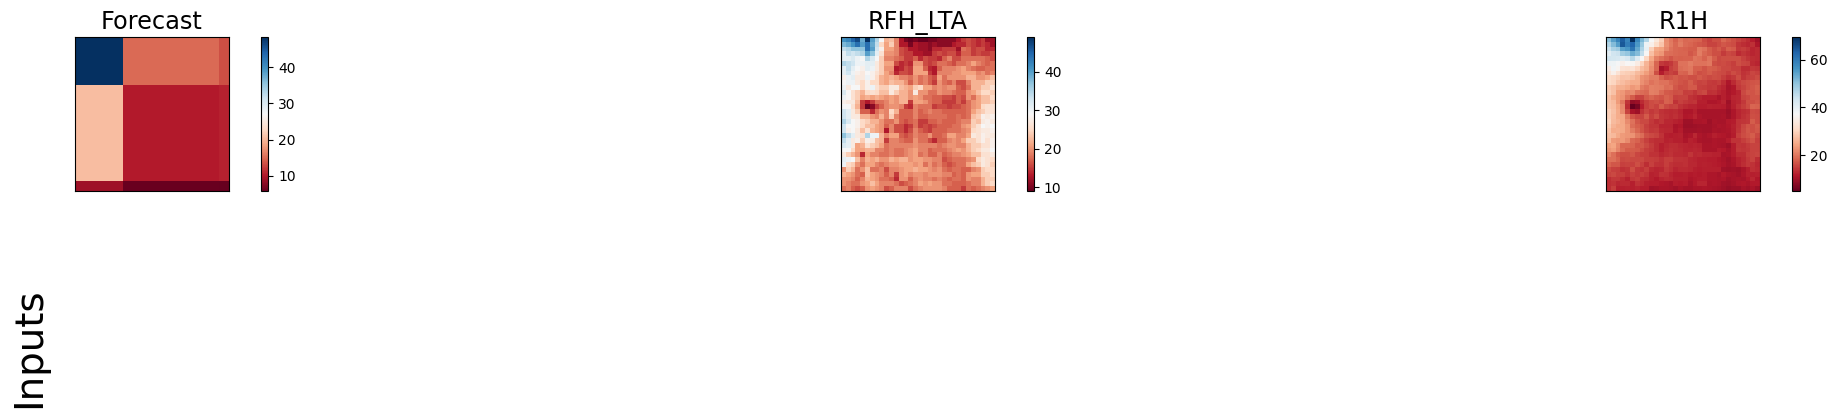

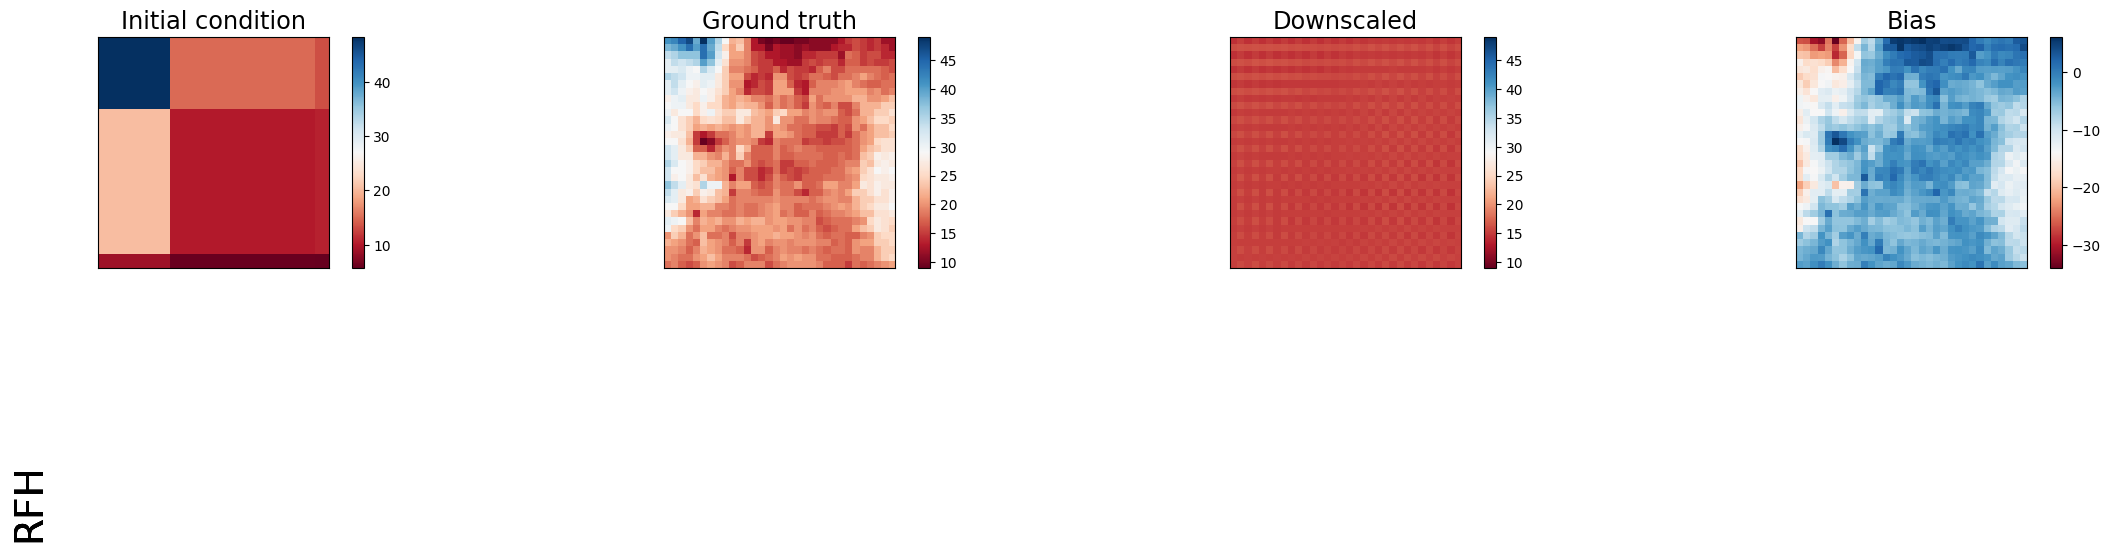

torch.Size([1, 32, 32])


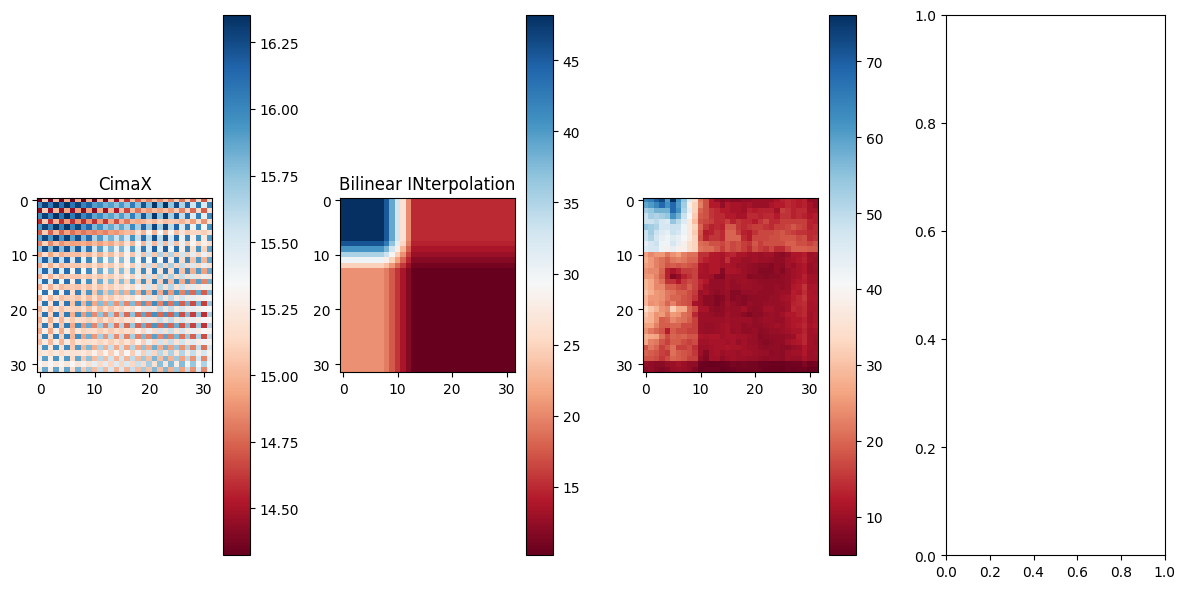

Time step 1


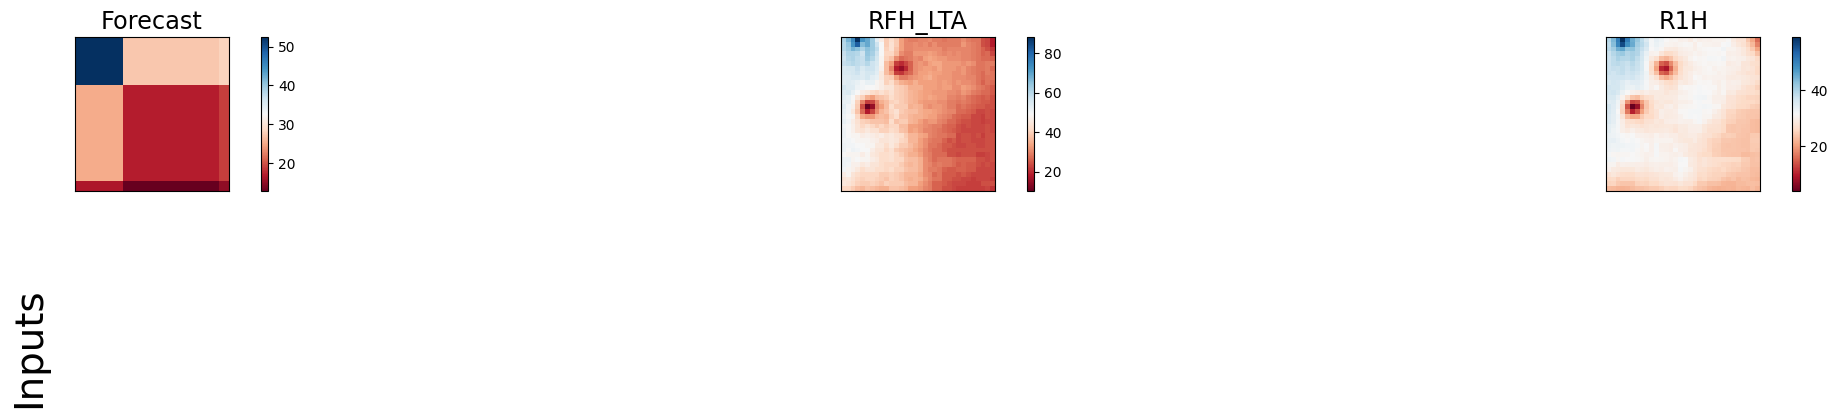

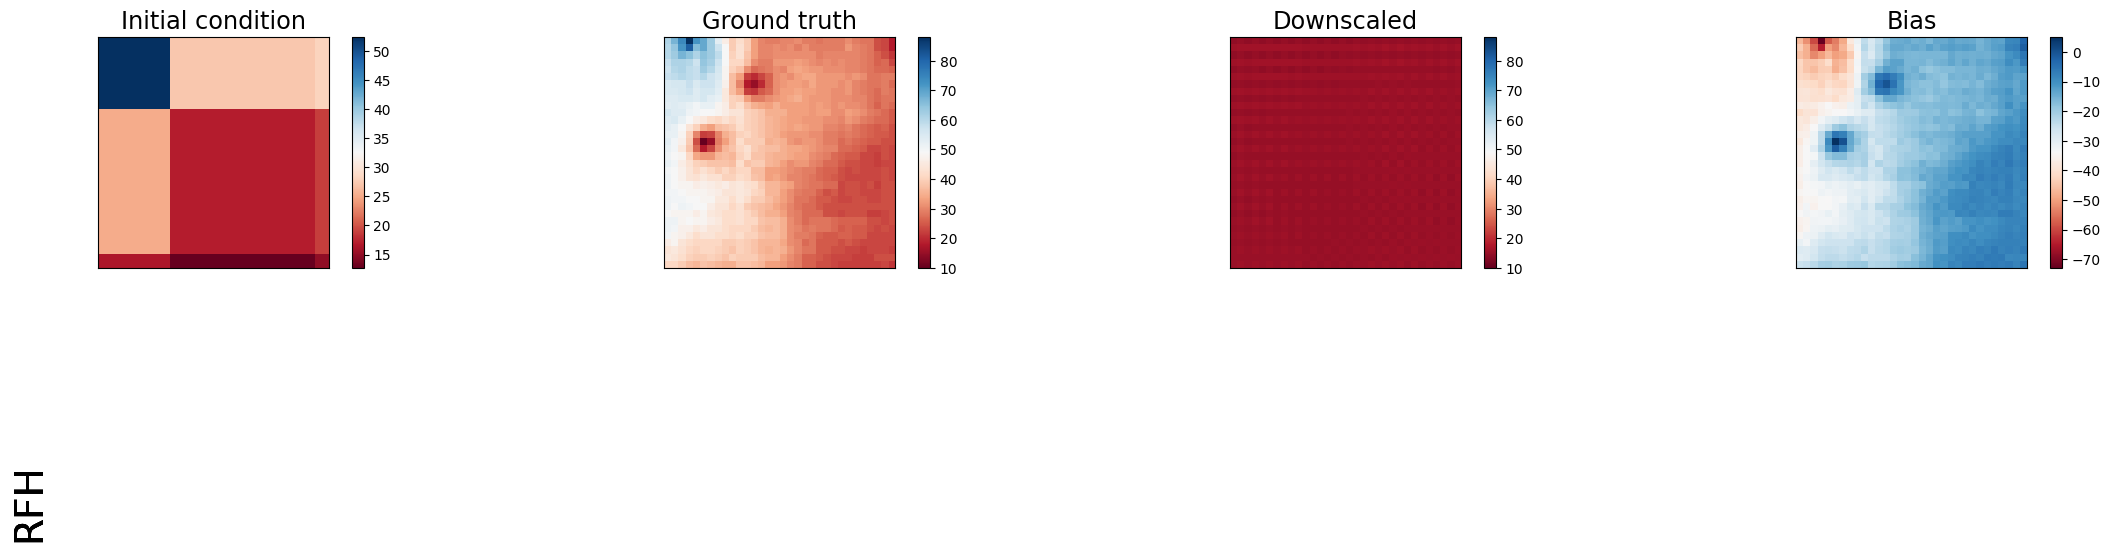

torch.Size([1, 32, 32])


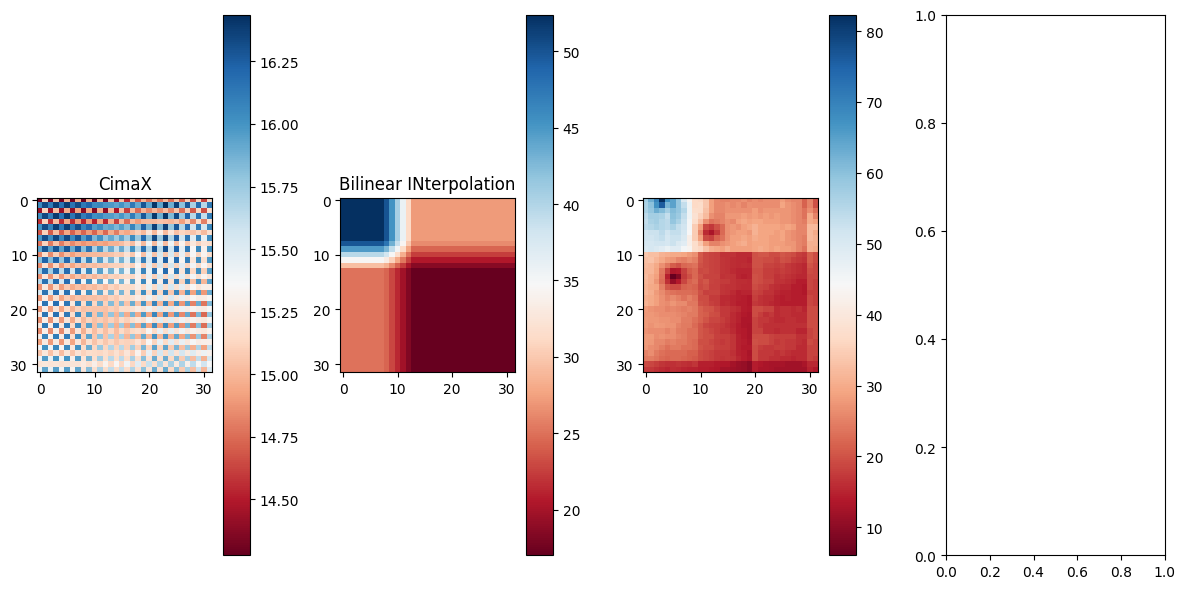

Time step 2


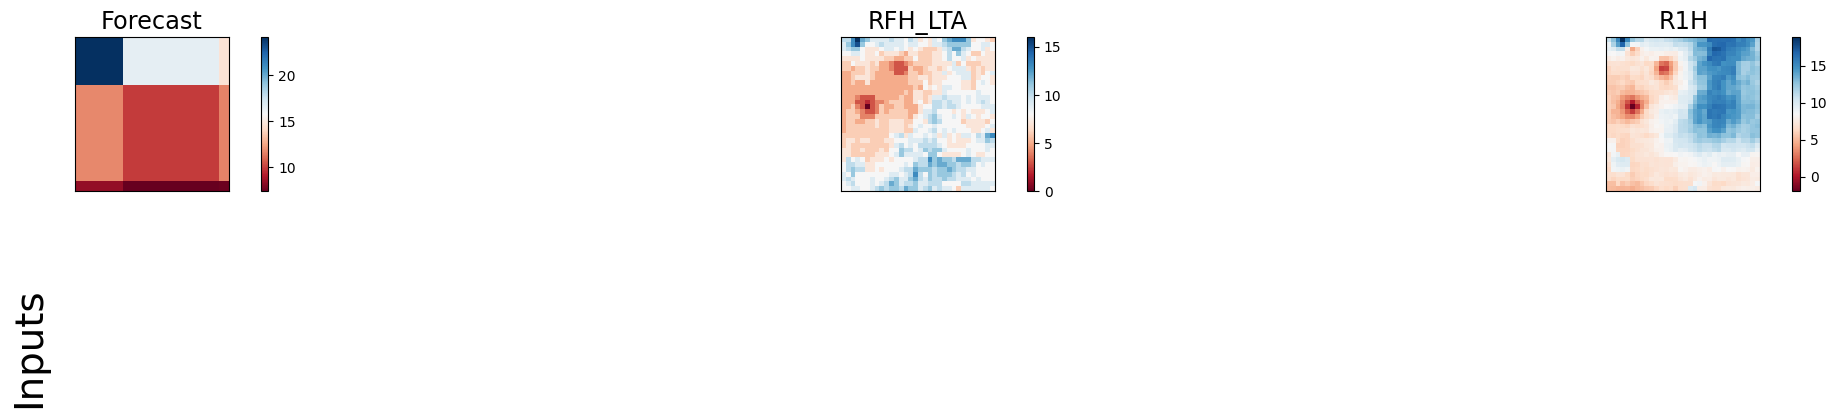

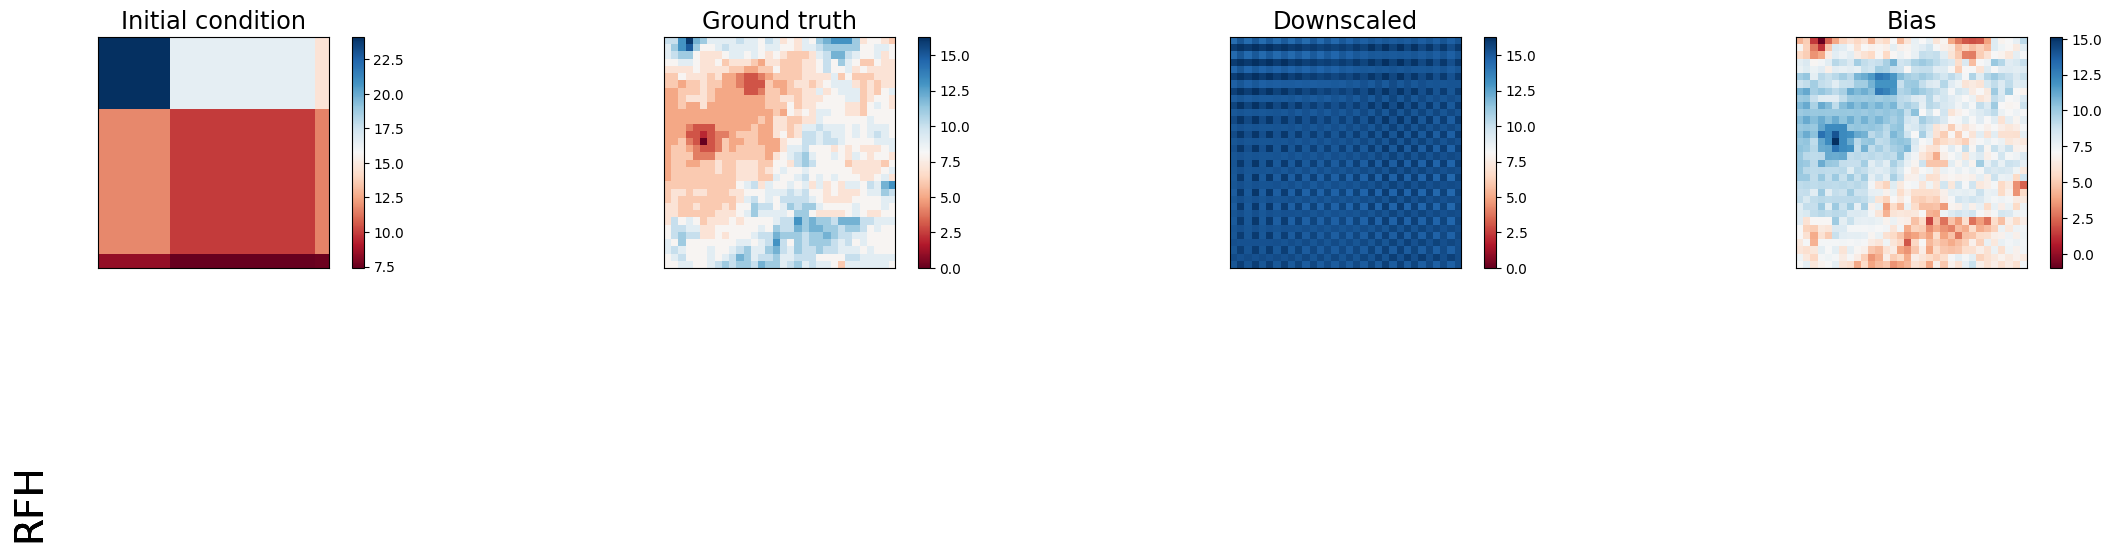

torch.Size([1, 32, 32])


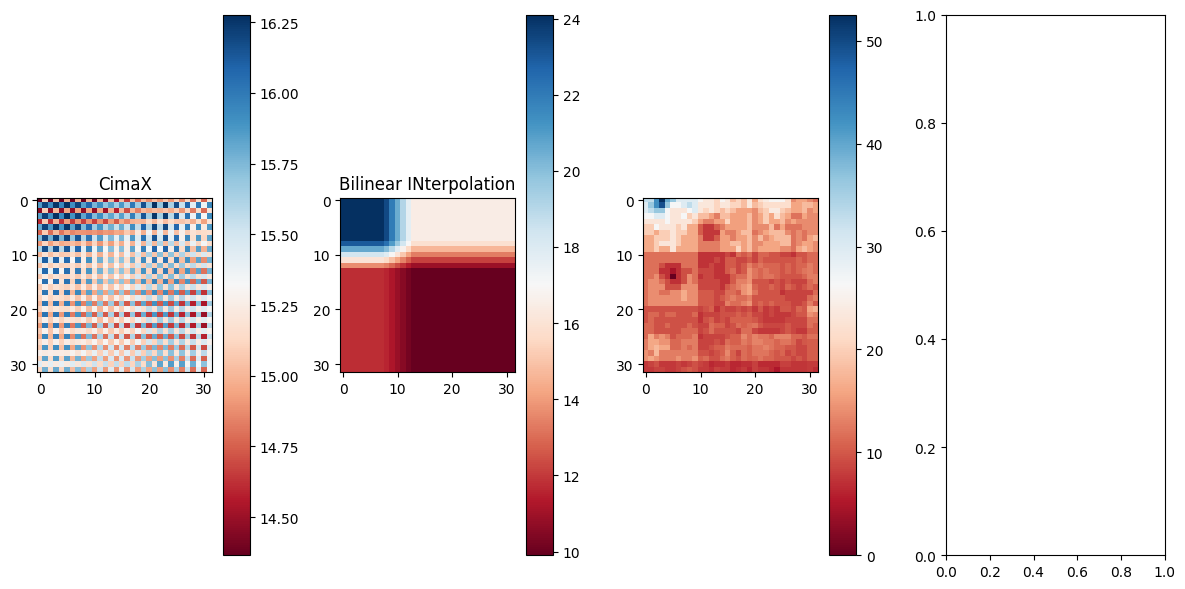

Time step 3


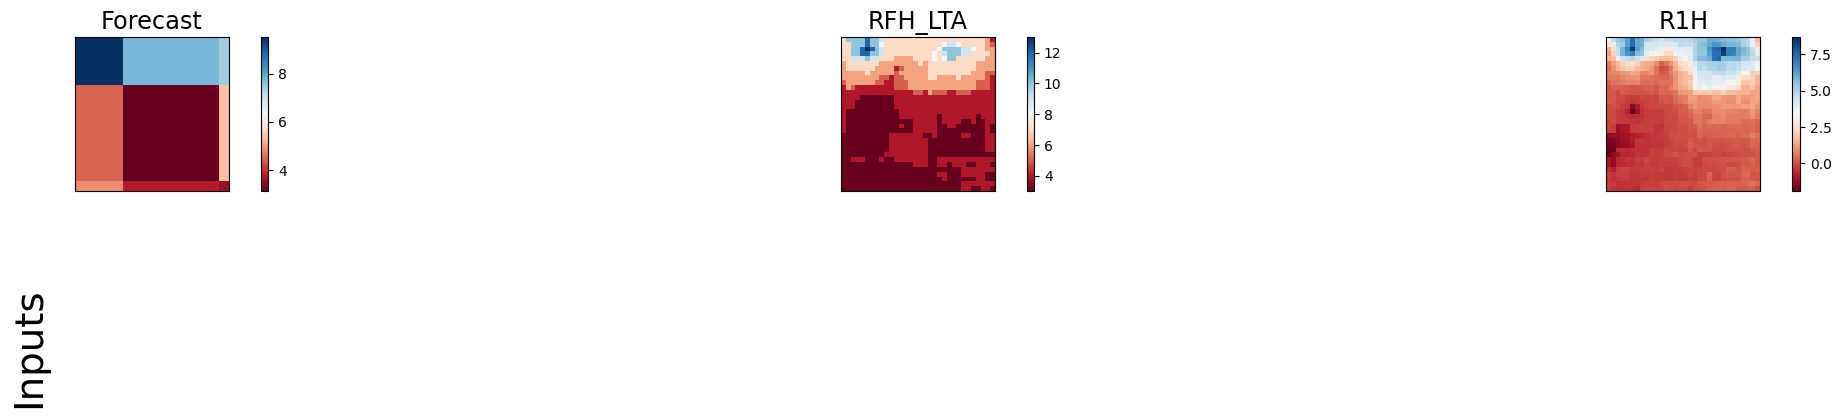

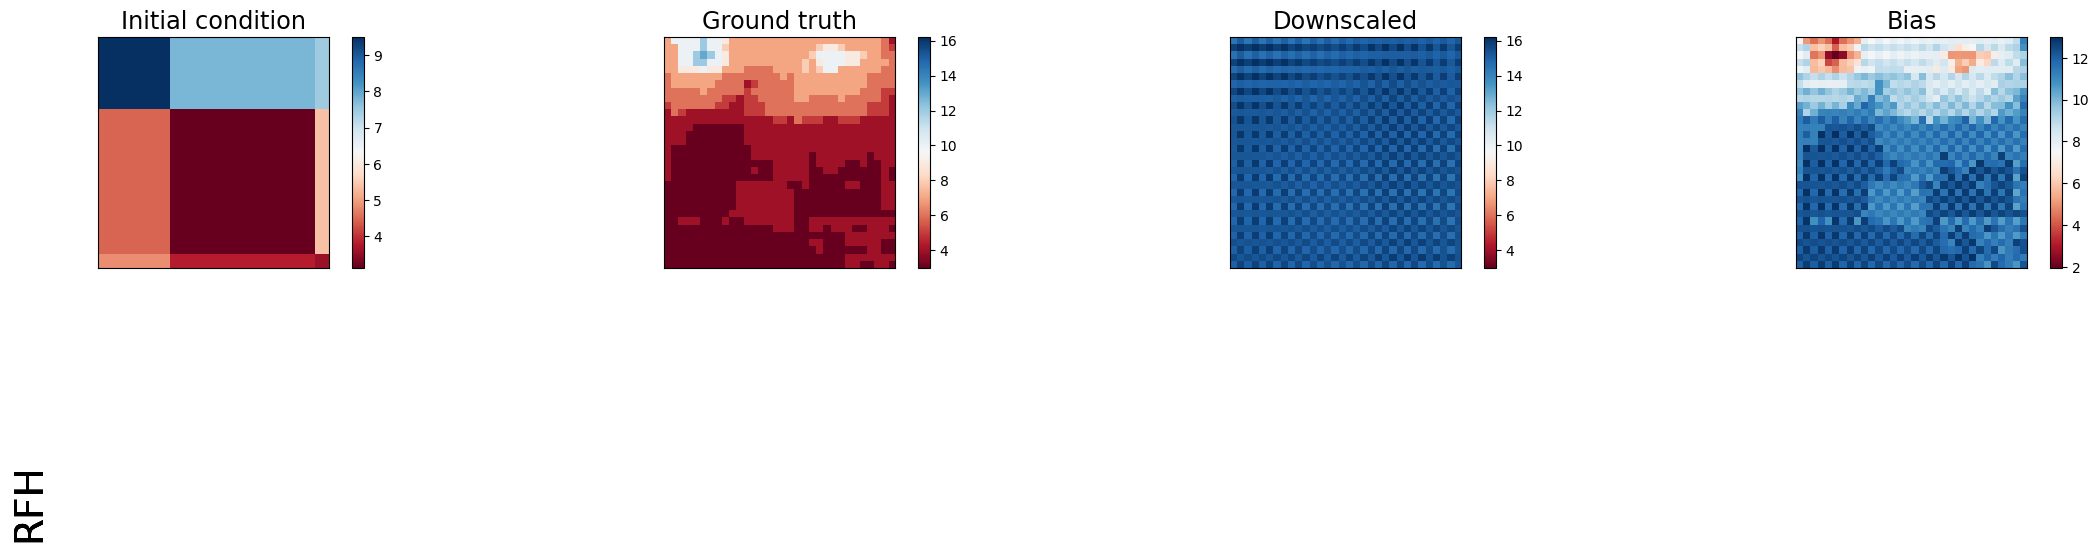

torch.Size([1, 32, 32])


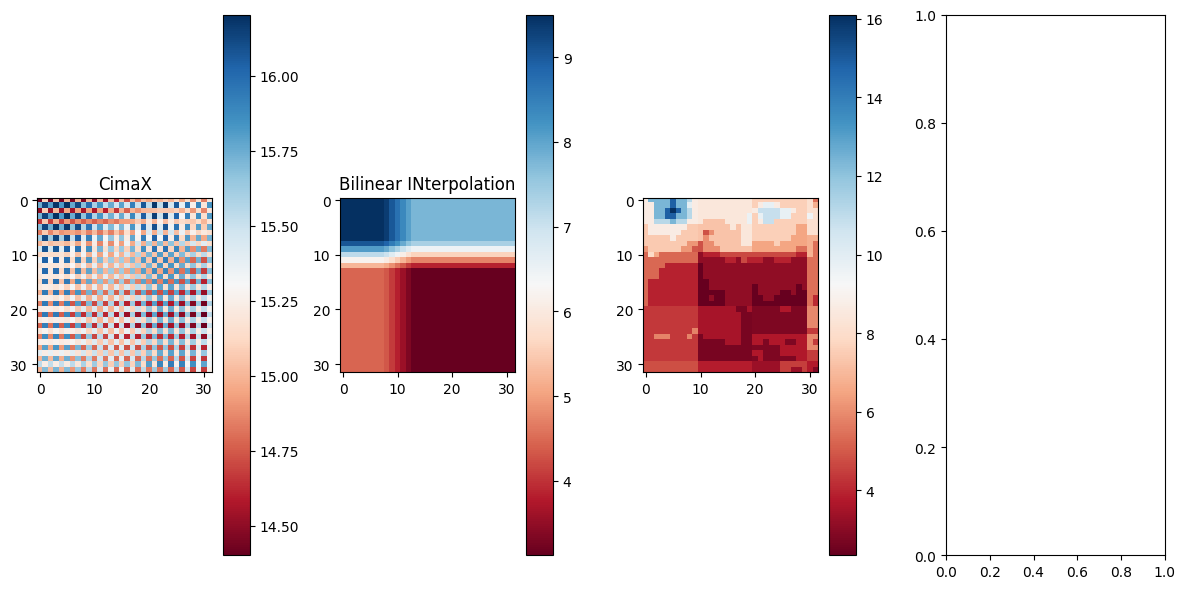

Time step 4


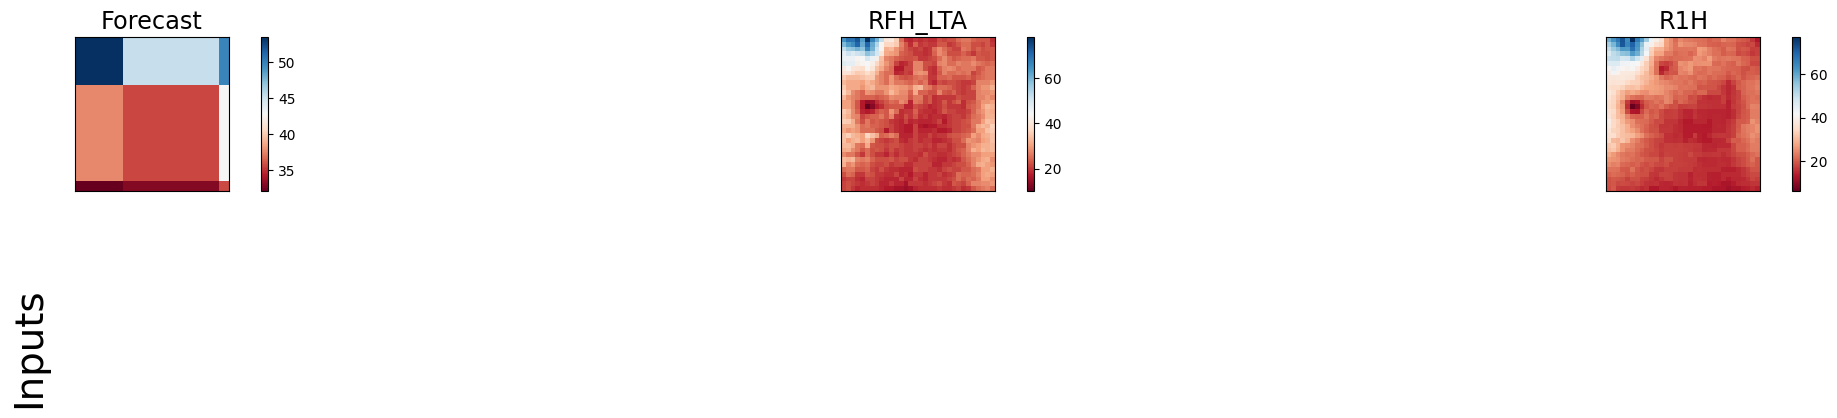

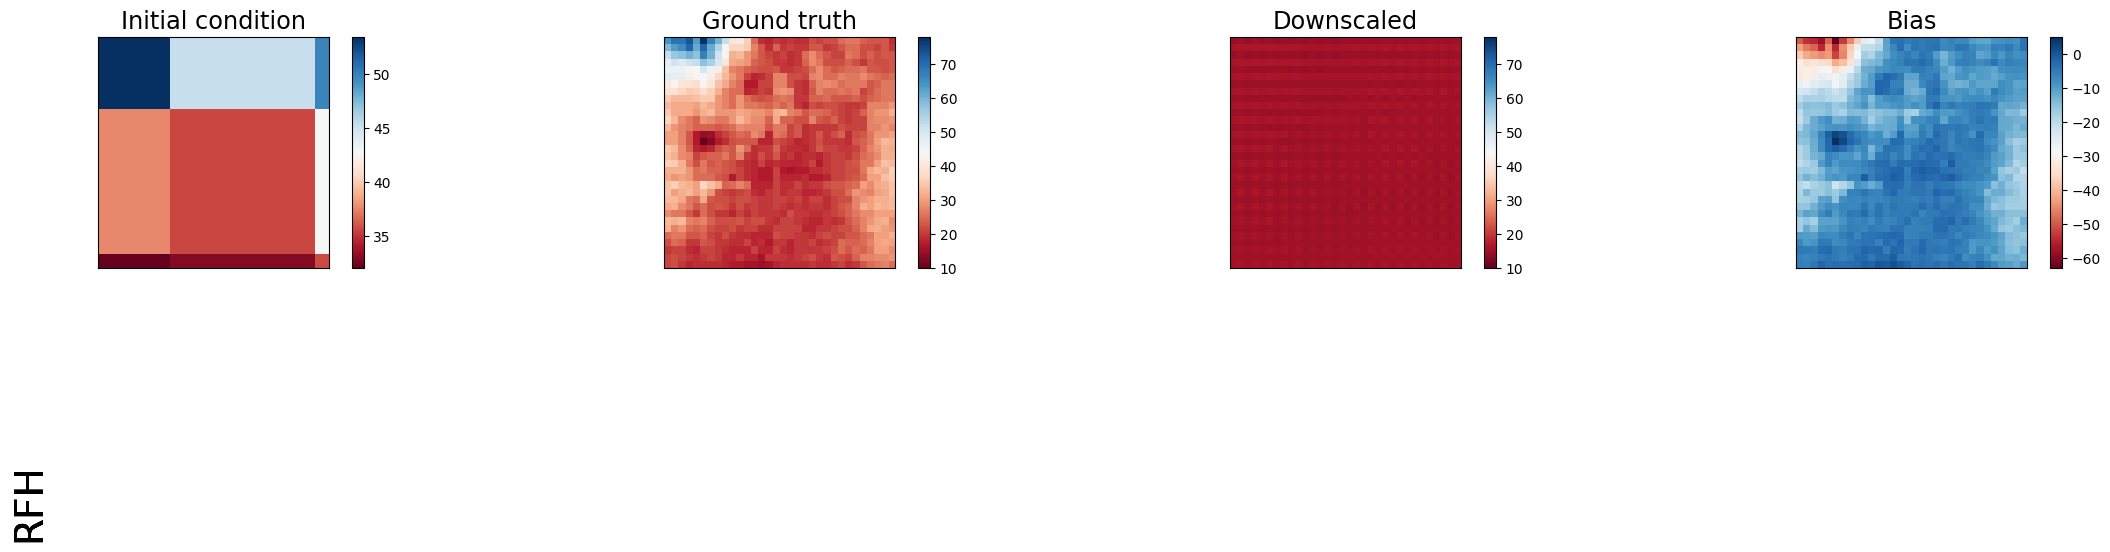

torch.Size([1, 32, 32])


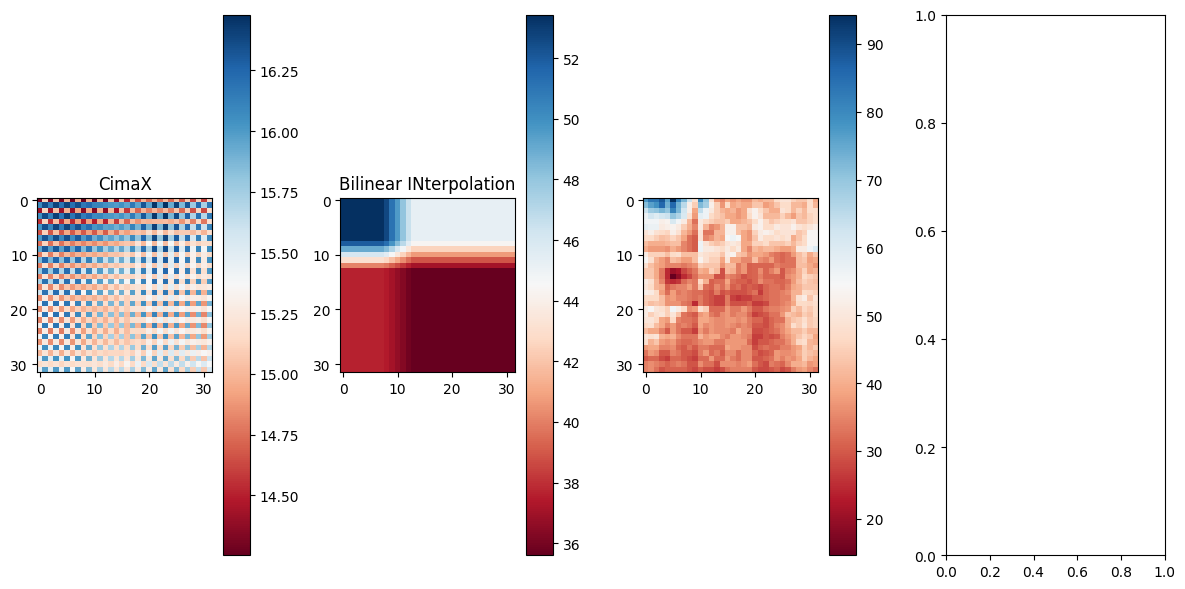

Time step 5


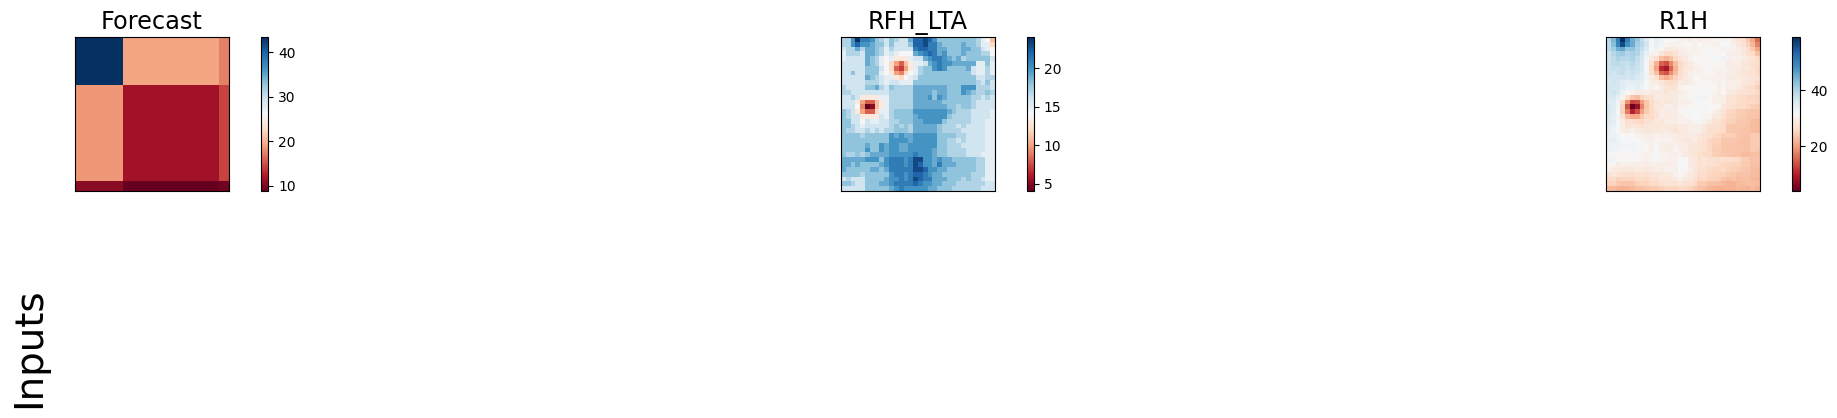

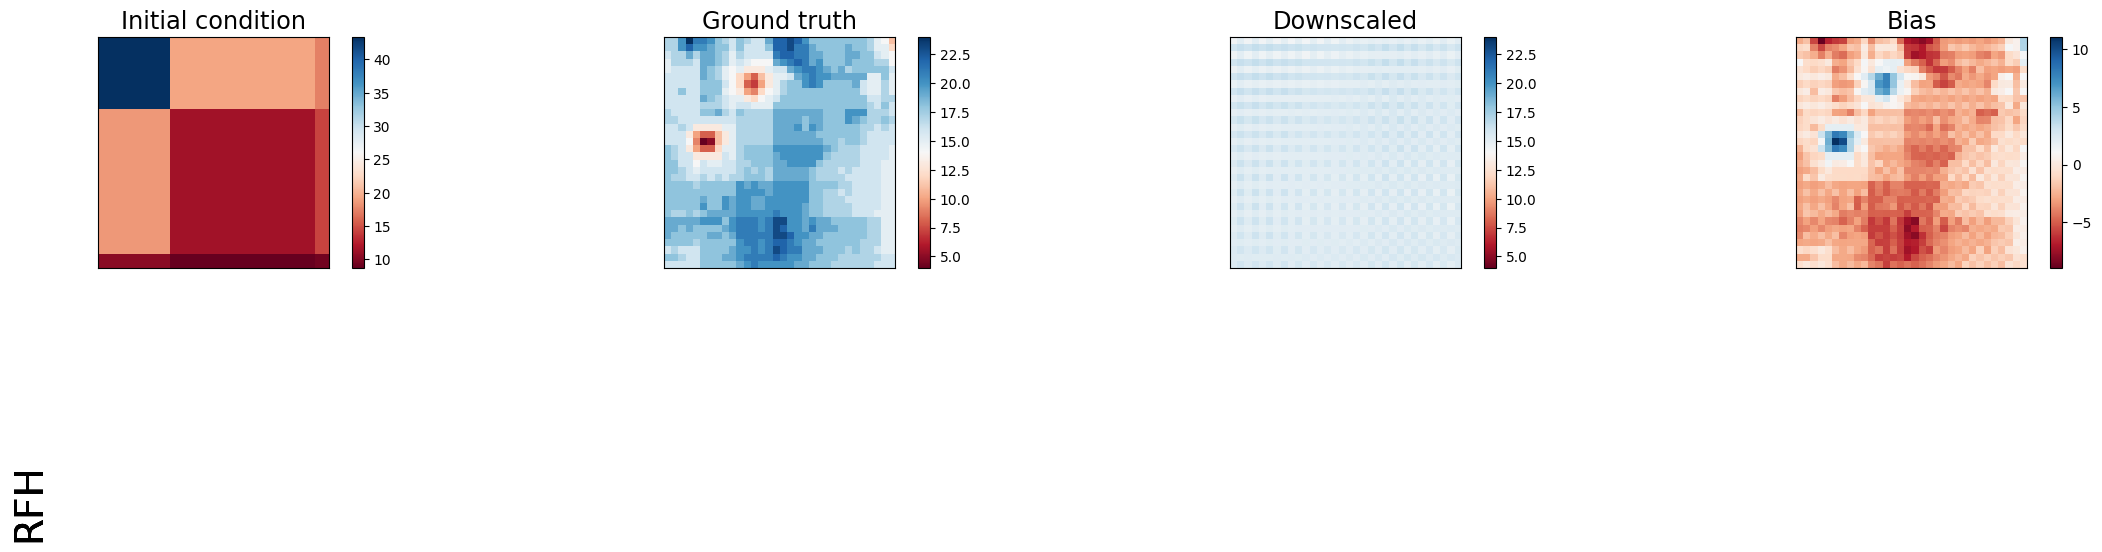

torch.Size([1, 32, 32])


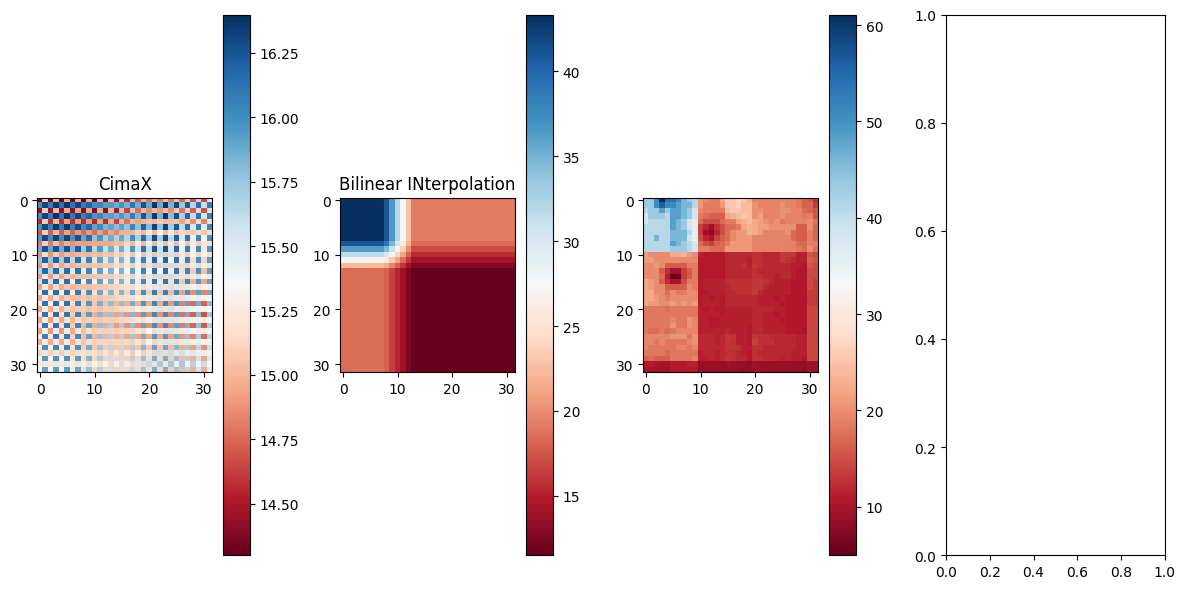

Time step 6


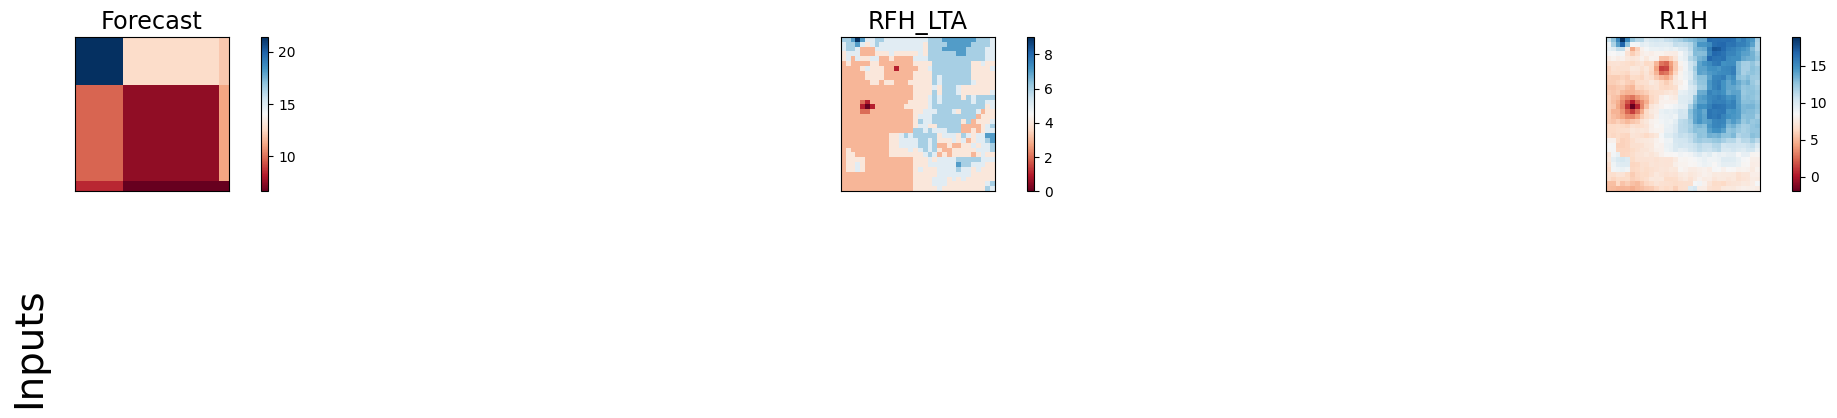

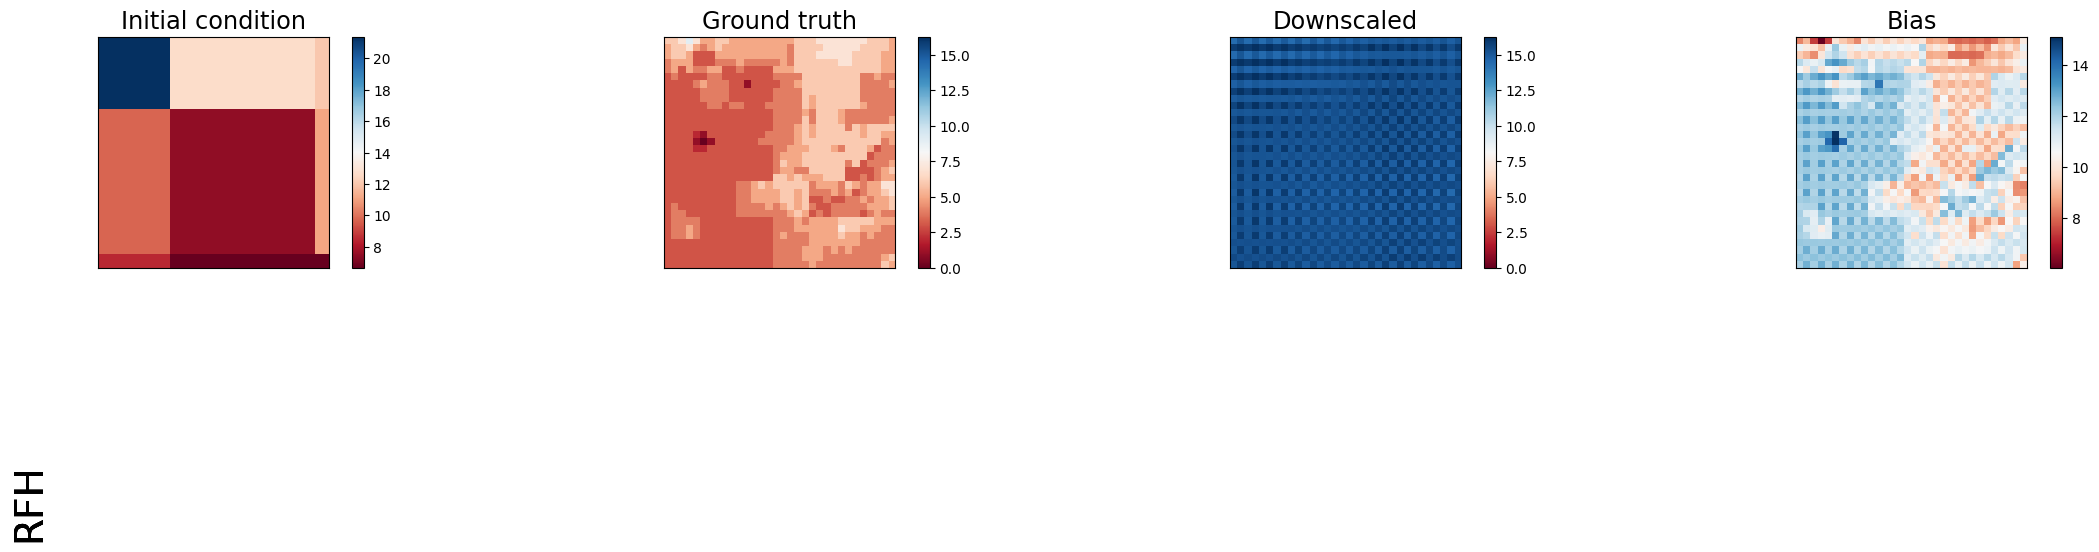

torch.Size([1, 32, 32])


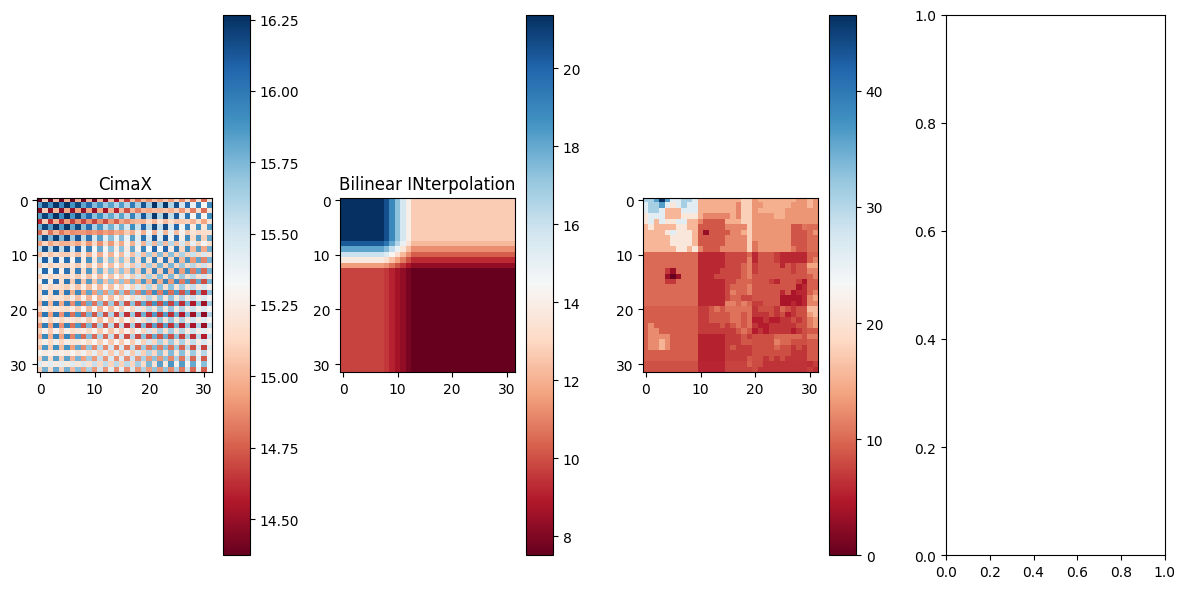

Time step 7


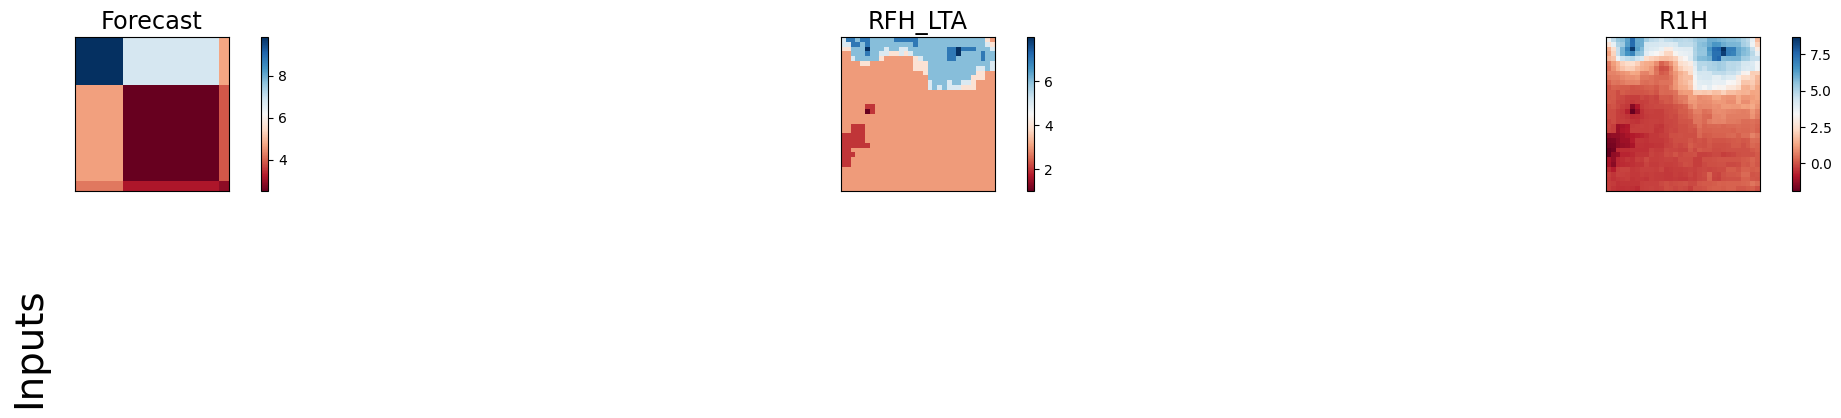

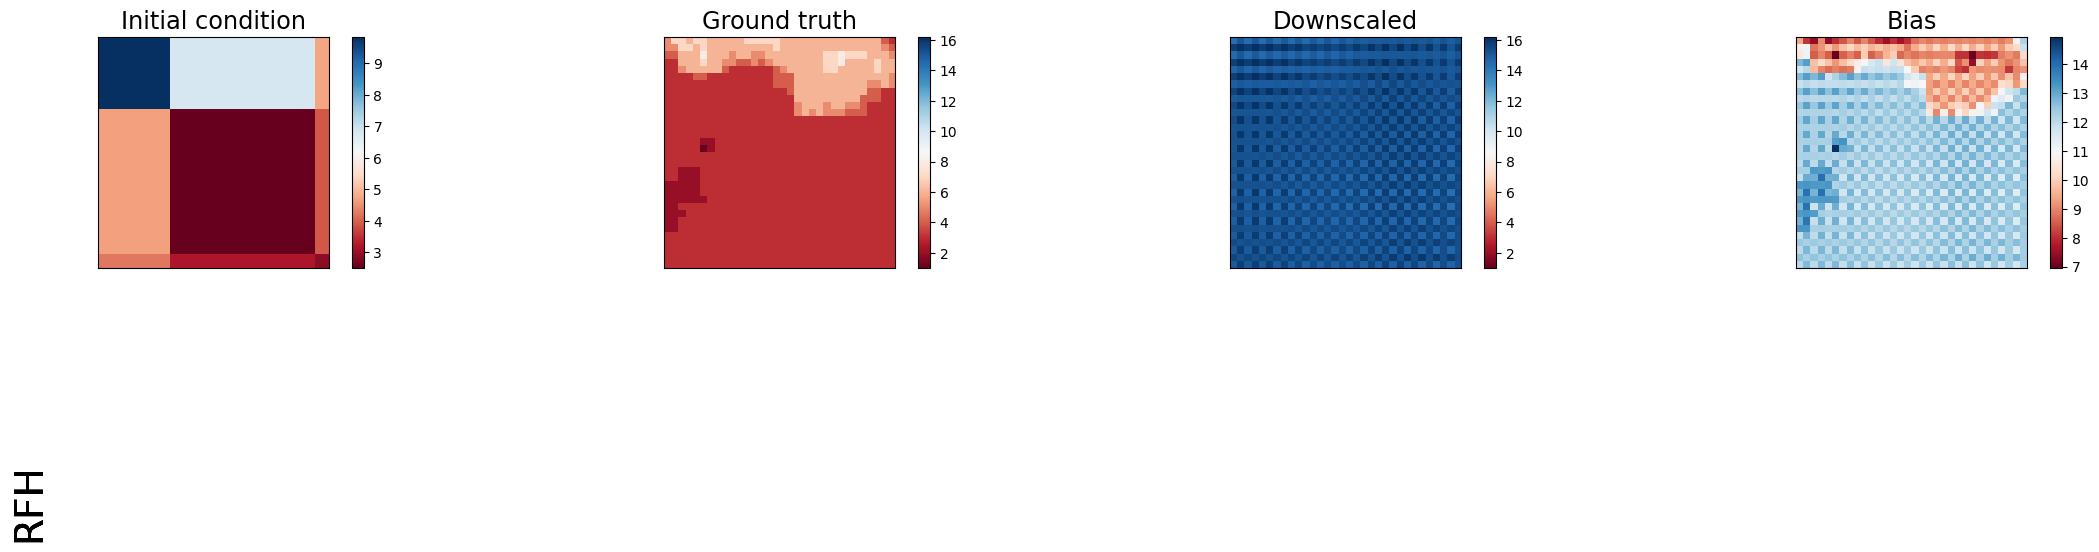

torch.Size([1, 32, 32])


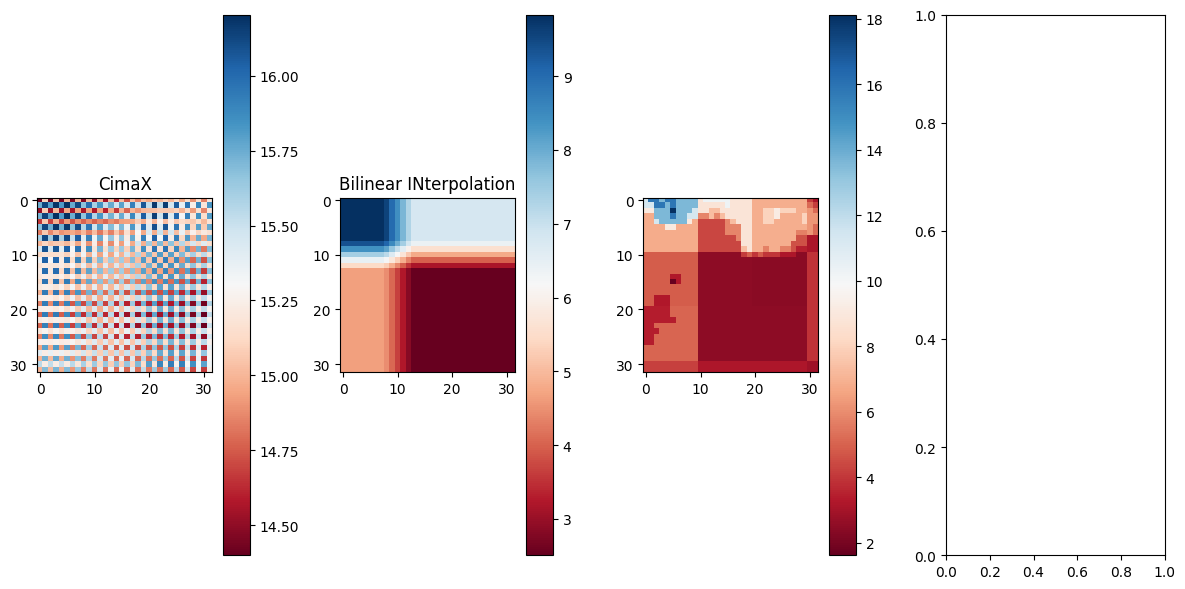

Time step 8


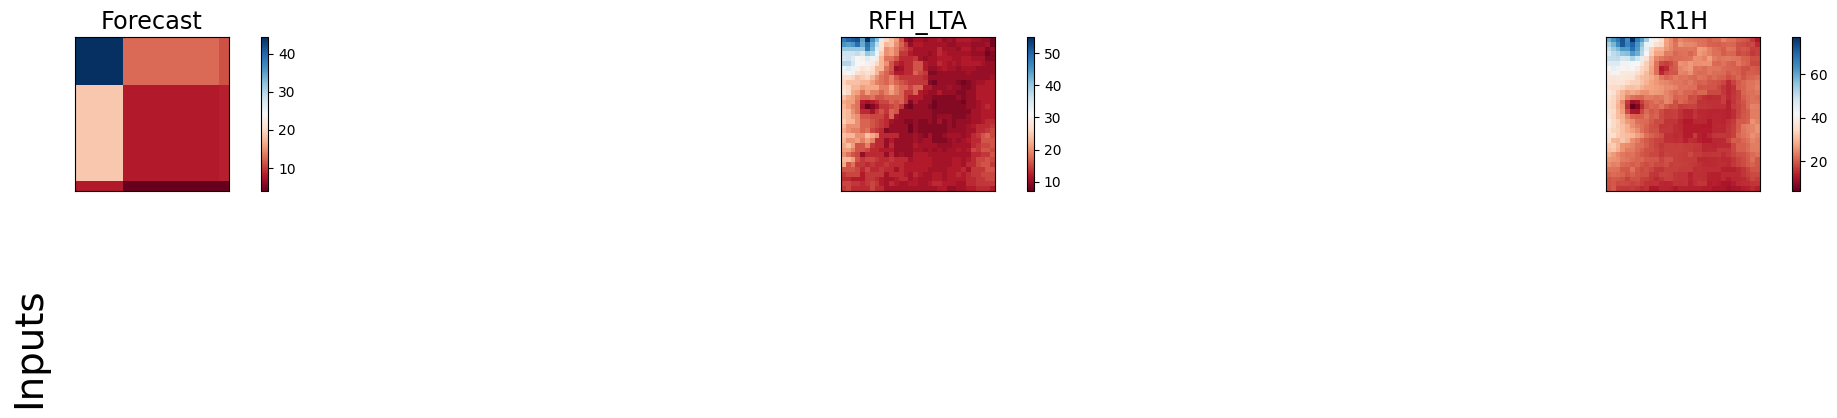

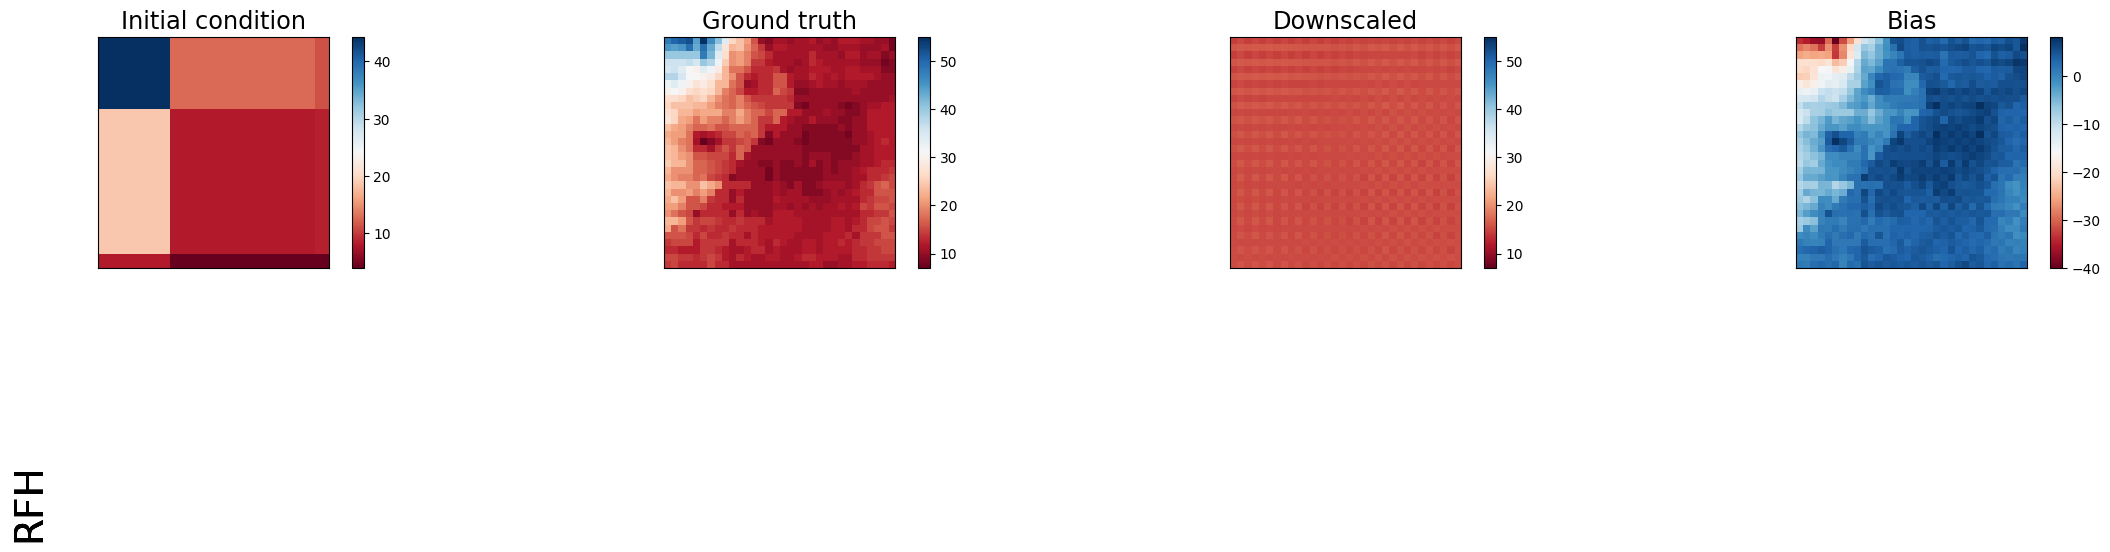

torch.Size([1, 32, 32])


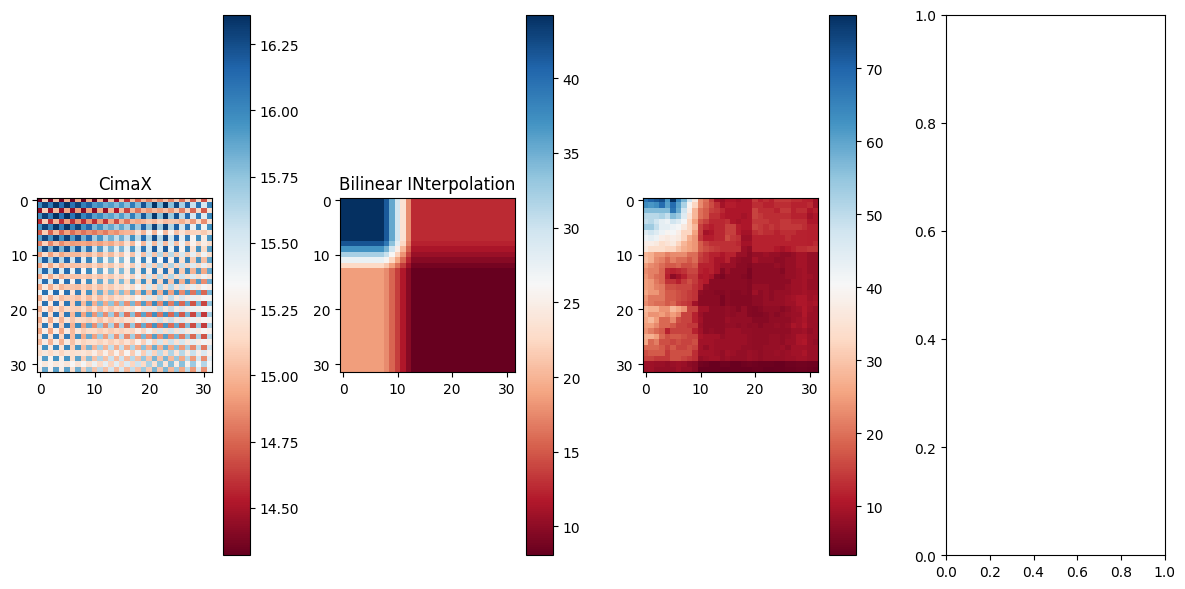

Time step 9


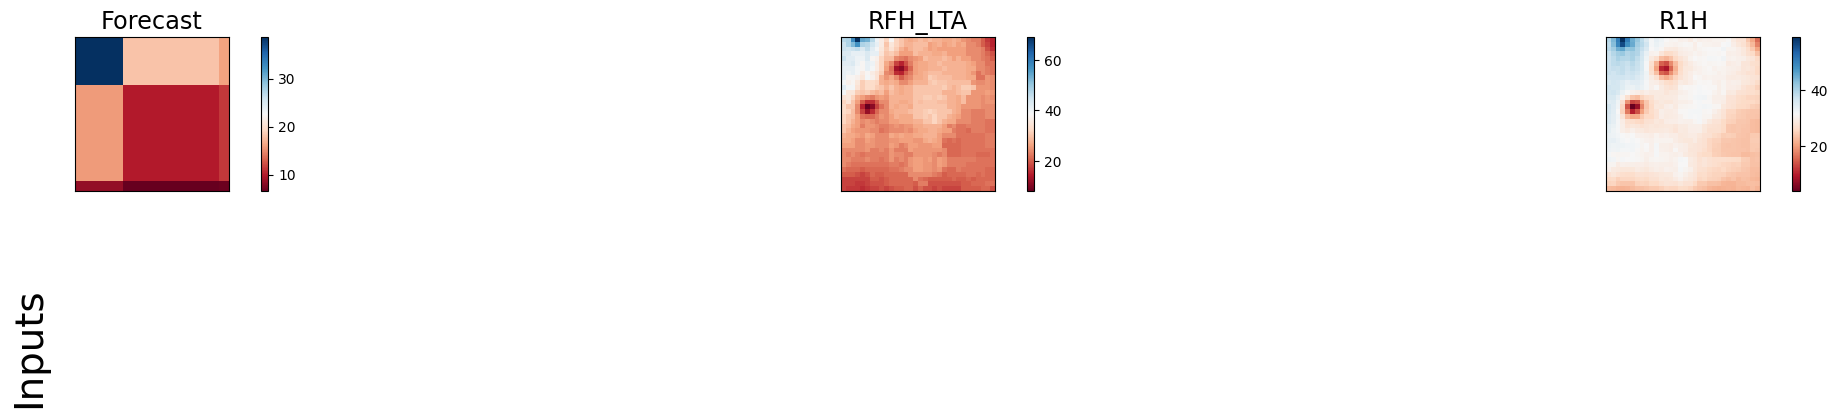

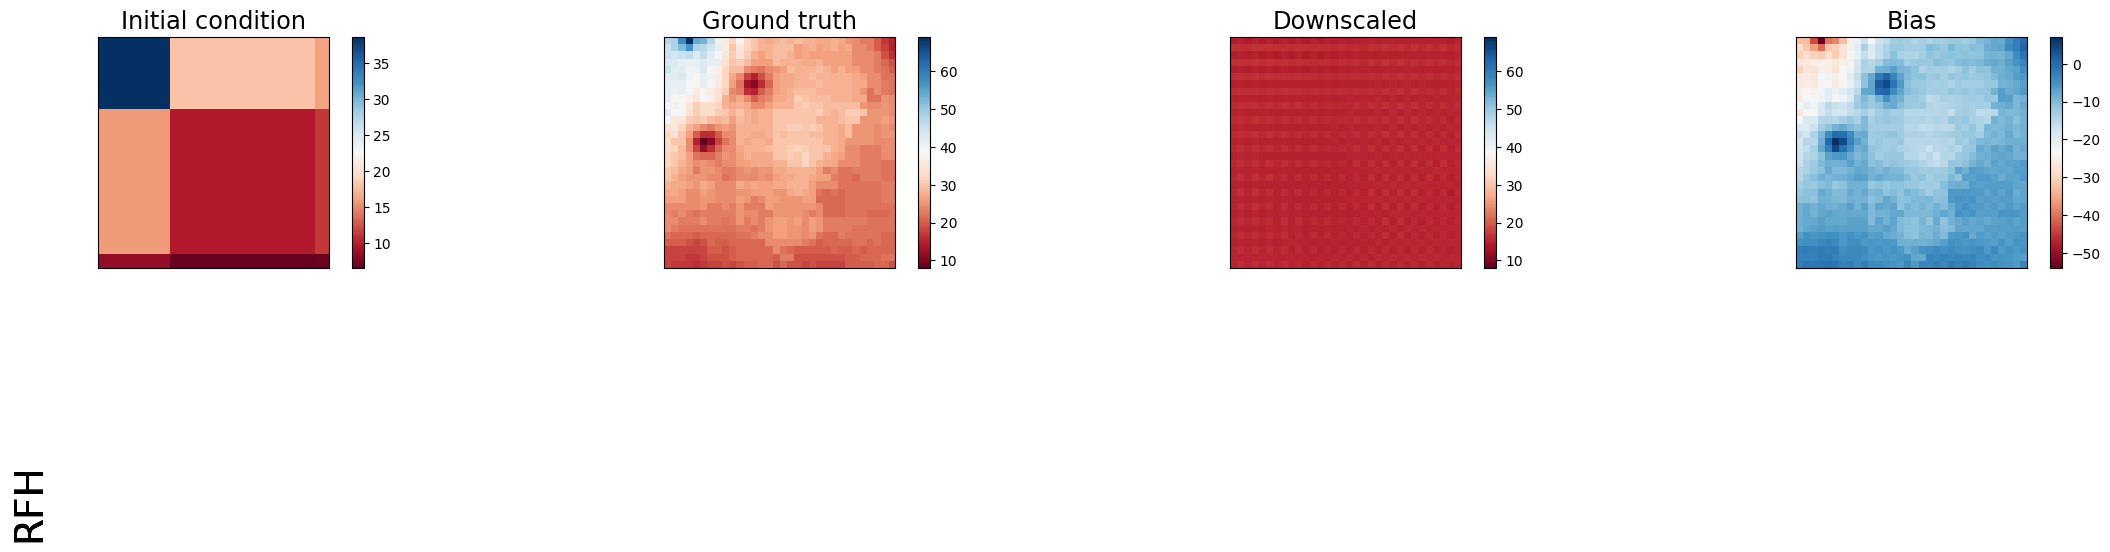

torch.Size([1, 32, 32])


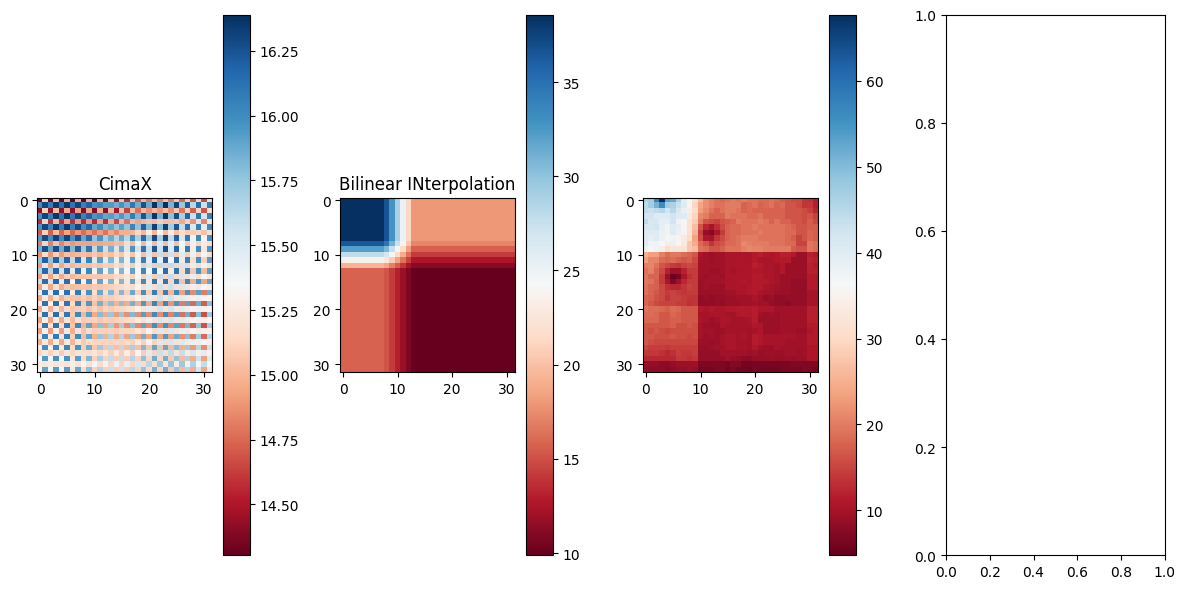

Time step 10


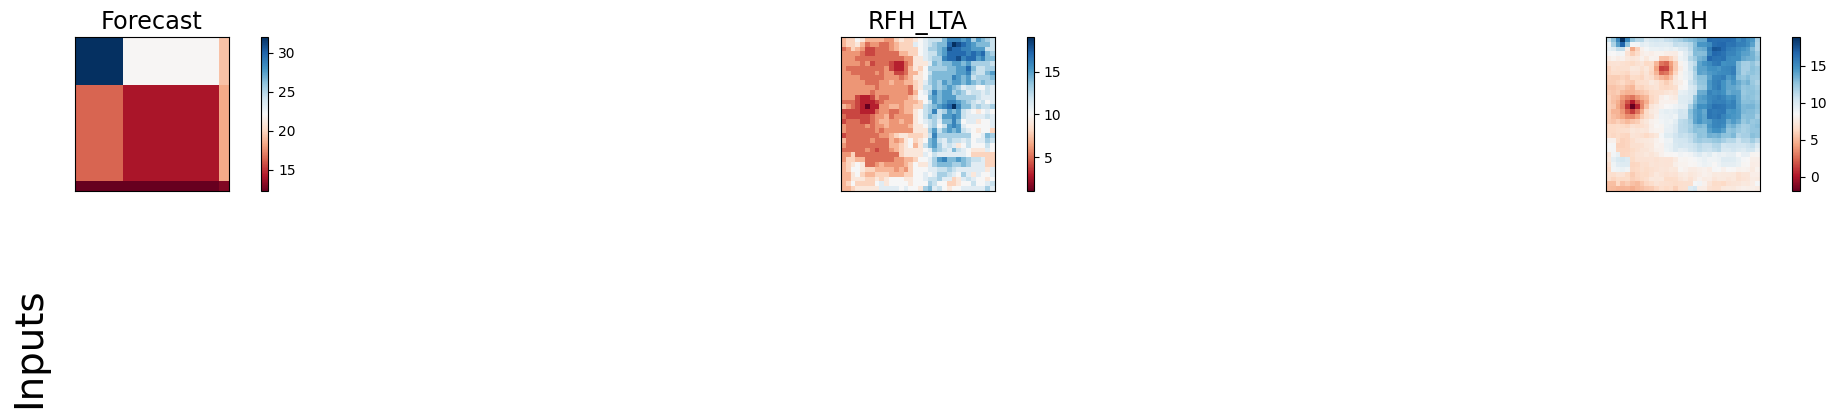

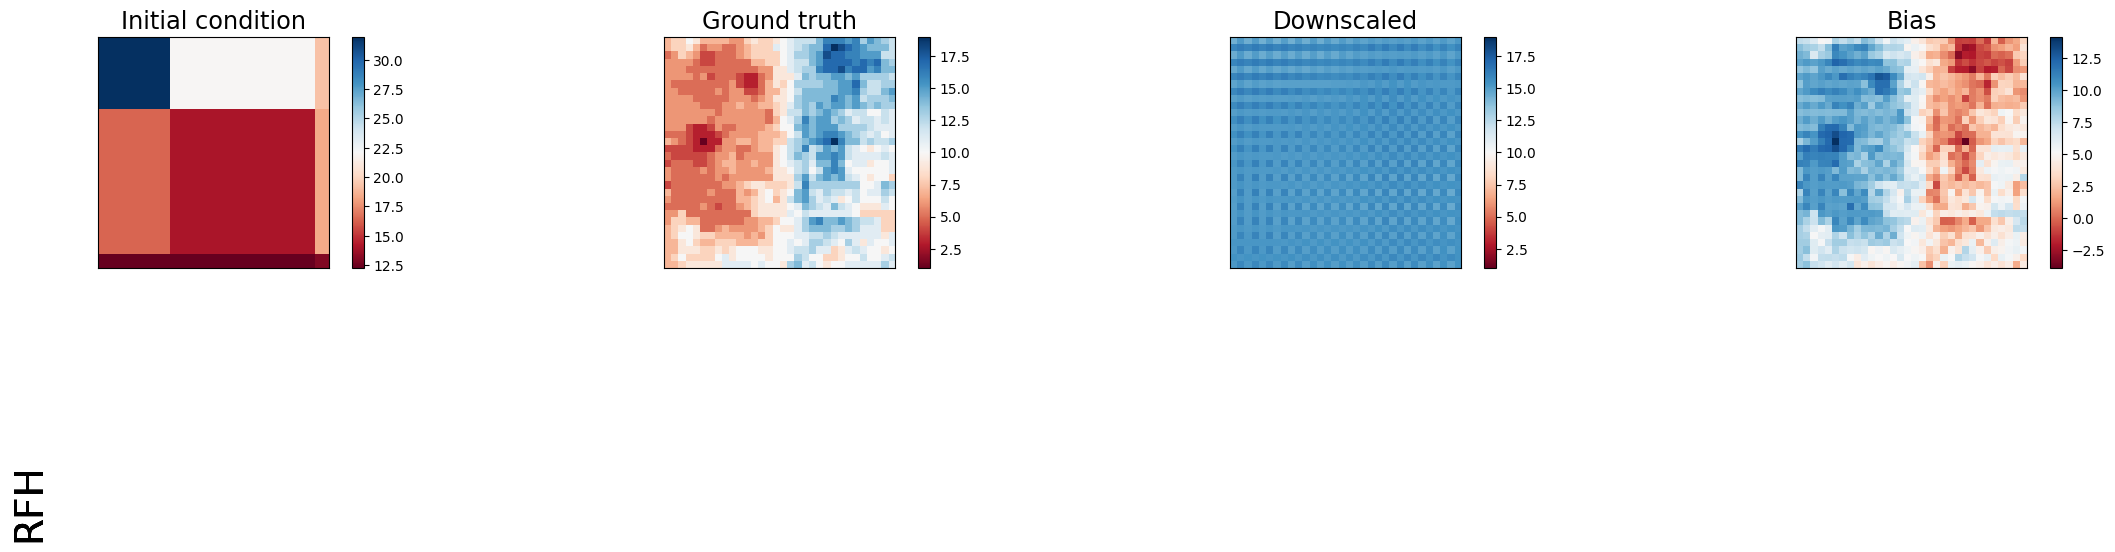

torch.Size([1, 32, 32])


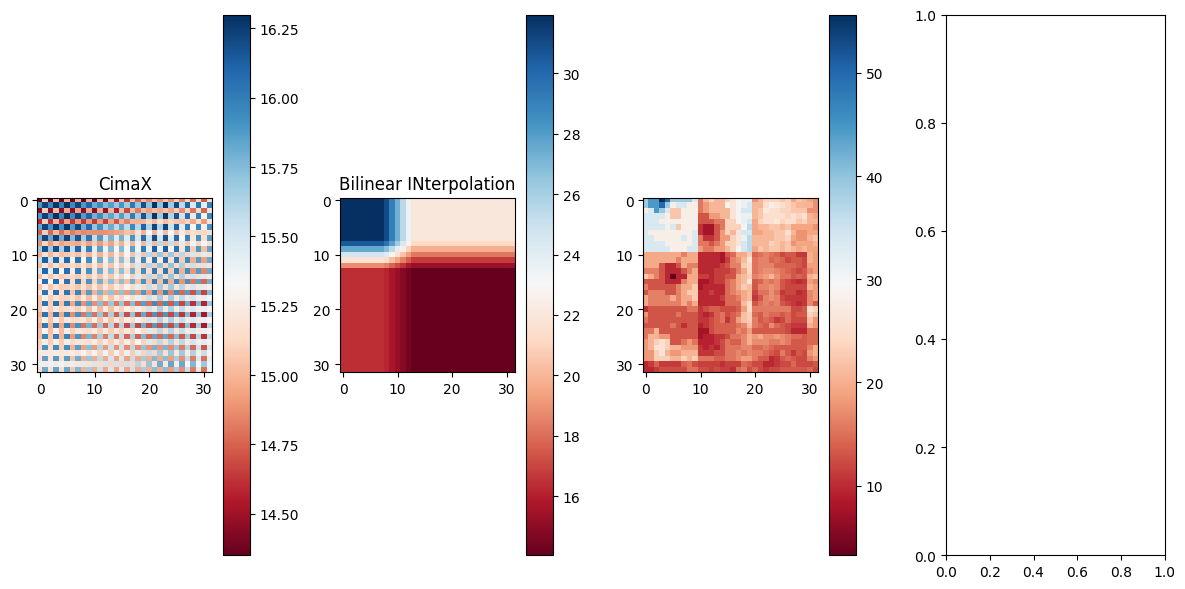

Time step 11


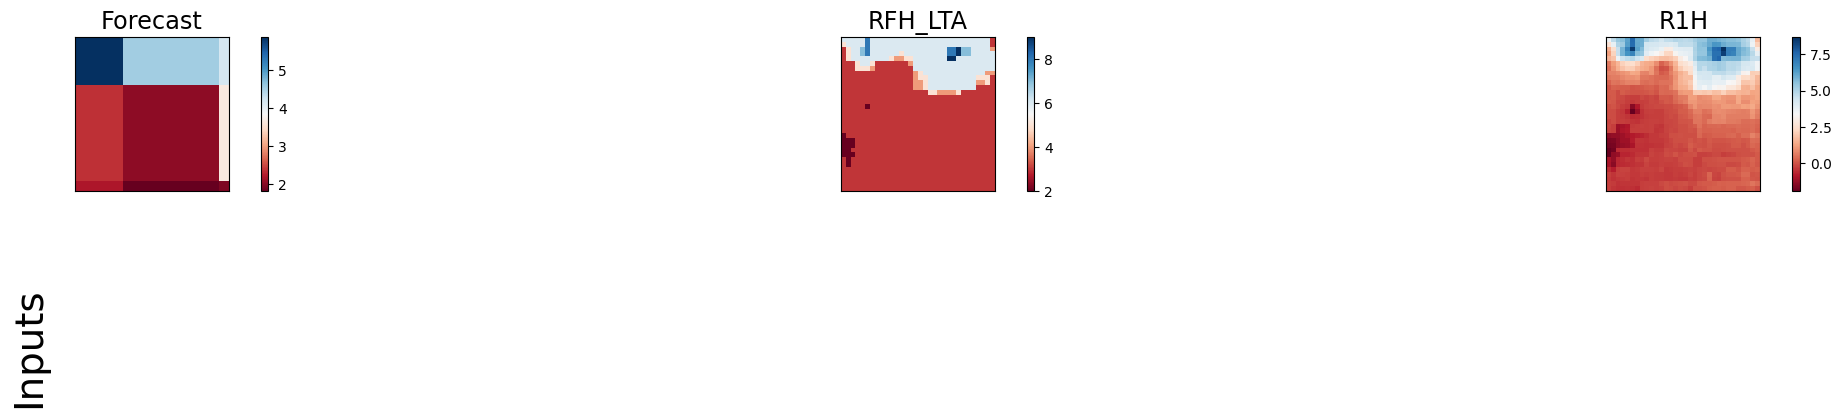

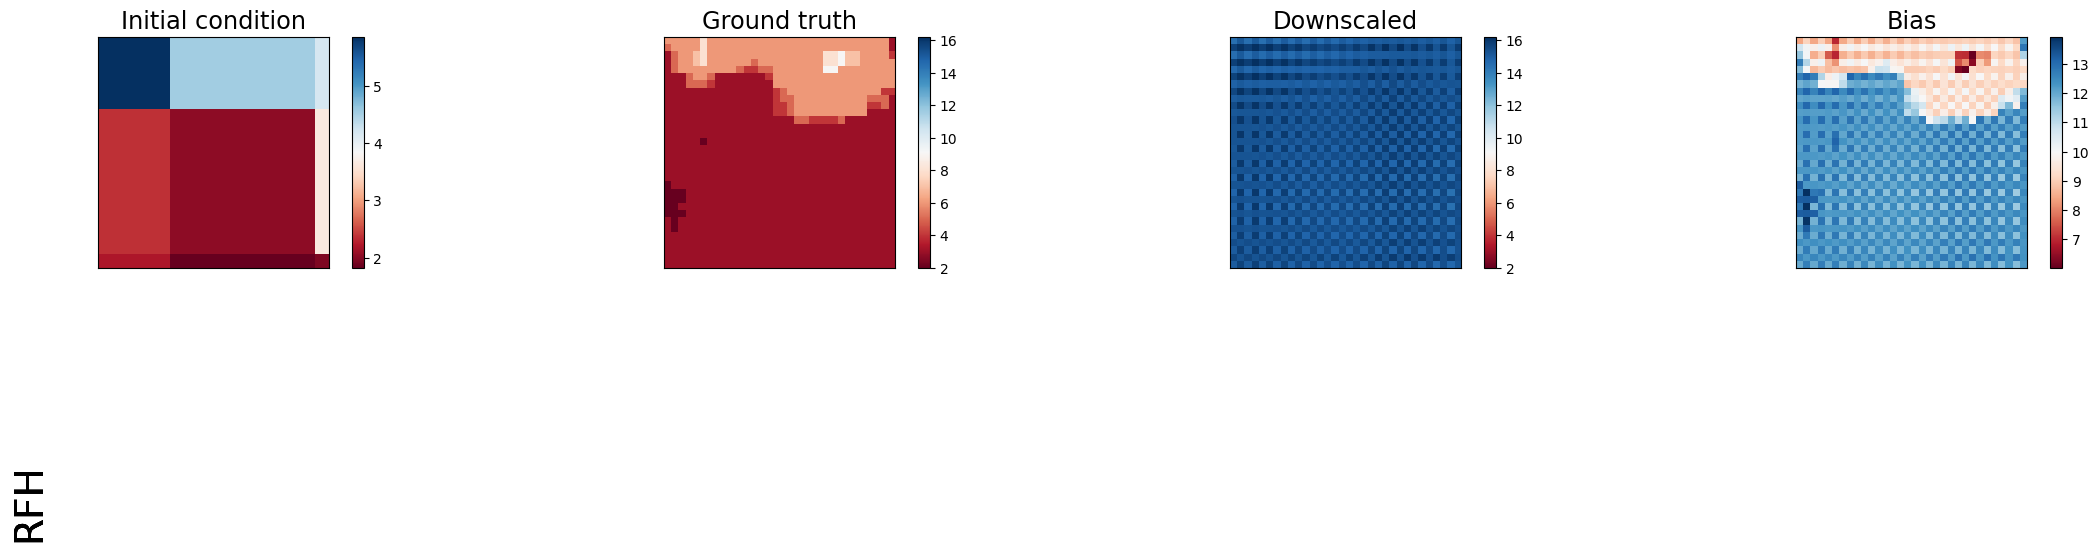

torch.Size([1, 32, 32])


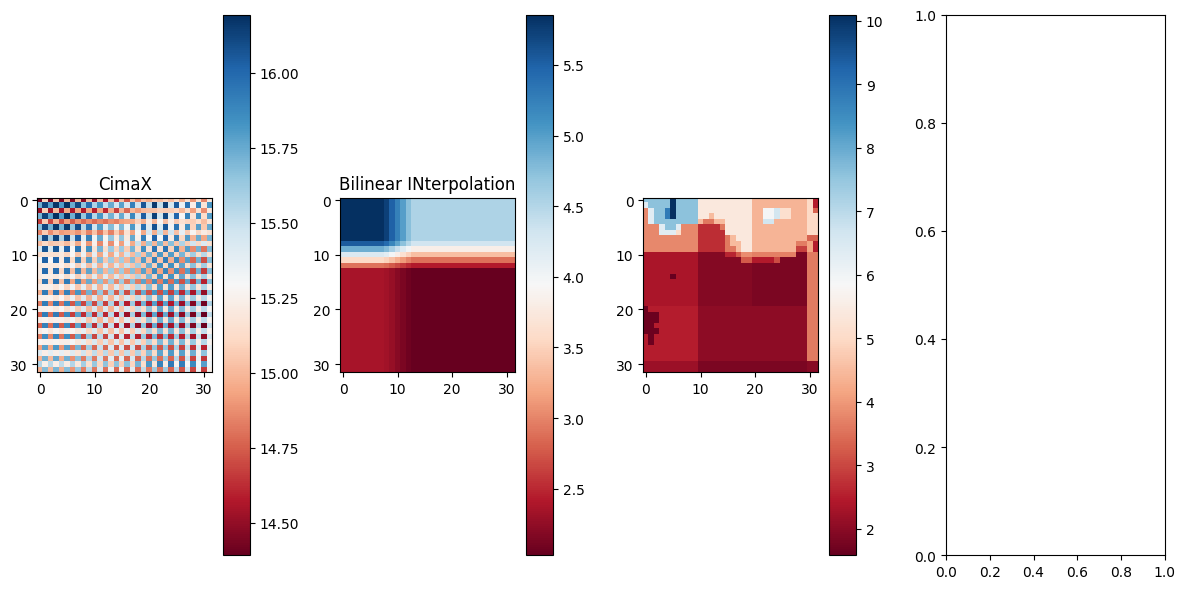

In [41]:
task = "10 days"
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        'forecast','rfh_lta','r1h','rfh']
    ,"img_size" :  [32, 32],
      "patch_size" :   2,
      "embed_dim":   1024,
      "depth" :  8,
      "decoder_depth" :  3,
      "num_heads": 16,
    "mlp_ratio": 2,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = ClimateDownscalingModule(net=net, pretrained_path='ClimaX/exps/downscale/checkpoints/epoch_015.ckpt')

datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Jordan_more/data_npz',
    variables=['forecast','r1h', 'rfh_lta',],
    out_variables=['rfh'],
    buffer_size= 2000,
    batch_size= 128
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())

datamodule.setup()


gt,pred,tensors,var_name, pred_task,tensors_pred = visualize_downscale(model, datamodule,mean_norm, std_norm, pred_range, var_name = "RFH", var_id = 1,desired_batch_index=1)
forecast, rfh_lta = tensors[0], tensors[1]
timesteps=gt.shape[0]




for t in range(timesteps):
    print("Time step",t)
    plot_inputs(tensors, var_name, pred_task,t)
    plot_pred(tensors_pred, var_name, pred_task,t)
    
    bilinear_inter = bilinear_interpolate(forecast[t].unsqueeze(dim=0))
    print(bilinear_inter.shape)
    
    weighted_mask = Downscale_Weight(rfh_lta[t].cpu().numpy(),forecast[t].cpu().numpy(), verbose=False)
    
    
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    # Plot the first figure on the left subplot
    im1 = axes[0].imshow(pred.cpu().numpy()[t][0], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[0].set_title('CimaX')

    # Plot the second figure on the right subplot
    im2 = axes[1].imshow(bilinear_inter.cpu().numpy()[0], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[1].set_title('Bilinear INterpolation')
    
    im3 = axes[2].imshow(weighted_mask, cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[1].set_title('Bilinear INterpolation')
    
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()




    



In [42]:
task = "10 days"
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        'forecast', 'rfh', 'rfh_lta']
    ,"img_size" :  [32, 32],
      "patch_size" :   4,
      "embed_dim":   1024,
      "depth" :  16,
      "decoder_depth" :  4,
      "num_heads": 1,
    "mlp_ratio": 4,
    "drop_path": 0.1,
    "drop_rate": 0.1,
    
}
net = ClimaX(**net_args)
model = ClimateDownscalingModule(net=net, pretrained_path='ClimaX/exps/downscale/checkpoints/epoch_005.ckpt')

datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Jordan/data_npz',
    variables=['forecast', 'rfh_lta', 'r1h'],
    out_variables=['rfh'],
    buffer_size= 1000,
    batch_size= 32
)

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())

datamodule.setup()

FileNotFoundError: [Errno 2] No such file or directory: 'ClimaX/exps/downscale/checkpoints/epoch_005.ckpt'

In [ ]:
gt,pred,tensors,var_name, pred_task,tensors_pred = visualize_downscale(model, datamodule,mean_norm, std_norm, pred_range, var_name = "RFH", var_id = 1,desired_batch_index=1)
forecast, rfh_lta = tensors[0], tensors[1]
timesteps=gt.shape[0]




for t in range(timesteps):
    print("Time step",t)
    plot_inputs(tensors, var_name, pred_task,t)
    plot_pred(tensors_pred, var_name, pred_task,t)
    
    bilinear_inter = bilinear_interpolate(forecast[t].unsqueeze(dim=0))
    print(bilinear_inter.shape)
    
    weighted_mask = Downscale_Weight(rfh_lta[t].cpu().numpy(),forecast[t].cpu().numpy(), verbose=False)
    
    
    
    fig, axes = plt.subplots(1, 4, figsize=(12, 6))

    # Plot the first figure on the left subplot
    im1 = axes[0].imshow(pred.cpu().numpy()[t][0], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[0].set_title('CimaX')

    # Plot the second figure on the right subplot
    im2 = axes[1].imshow(bilinear_inter.cpu().numpy()[0], cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[1].set_title('Bilinear INterpolation')
    
    im3 = axes[2].imshow(weighted_mask, cmap=plt.cm.RdBu)  # You can change the colormap as needed
    axes[1].set_title('Bilinear INterpolation')
    
    fig.colorbar(im1)
    fig.colorbar(im2)
    fig.colorbar(im3)

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()




    
